# Leave One Country Out vs Single country
## This shows the rmse breakdowns so which can be compared and seen easier

### Imports

In [95]:
import pandas as pd
import numpy as np
import pickle
import os
import gc
import warnings
from collections import defaultdict
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Input
from tensorflow.keras.layers import Conv1D, Flatten, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

warnings.filterwarnings("ignore")

In [96]:
### Configuration
TARGET_VARIABLES = ['co2', 'gdp', 'primary_energy_consumption']
N_STEPS_IN = 5
N_STEPS_OUT = 3
# Setting test size as 9 samples
TEST_SAMPLES = 9
MAX_LAGS = 4

G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]

FEATURES = [
    'fossil_fuel_consumption', 'energy_per_capita',
    'electricity_generation', 'population',
    'nuclear_consumption', 'renewables_consumption'
]

DEVELOPED_COUNTRIES = [
    'United States', 'Japan', 'Germany', 'United Kingdom',
    'France', 'Italy', 'Canada', 'Australia', 'South Korea'
]

DEVELOPING_COUNTRIES = [
    'China', 'Brazil', 'Russia', 'India', 'Mexico', 'Indonesia',
    'Turkey', 'Saudi Arabia', 'South Africa', 'Argentina'
]

### Utility Functions

In [97]:
def clear_memory():
    tf.keras.backend.clear_session()
    gc.collect()

In [98]:
def rmse(y_pred, y_actual):
    y_pred = np.atleast_1d(y_pred)
    y_actual = np.atleast_1d(y_actual)
    
    if len(y_pred) == 1 and len(y_actual) == 1:
        # Single value case
        return np.sqrt((y_pred[0] - y_actual[0]) ** 2)
    else:
        # Array case
        return np.sqrt(mean_squared_error(y_actual, y_pred))

In [99]:
def mase(y_actual, y_pred, period=1):
    y_pred = np.atleast_1d(y_pred)
    y_actual = np.atleast_1d(y_actual)
    
    if len(y_pred) == 1 and len(y_actual) == 1:
        # For single values, return absolute error
        return np.abs(y_pred[0] - y_actual[0])

    mae_forecast = mean_absolute_error(y_actual, y_pred)
    
    # MAE of naive forecast
    naive_forecast = y_actual[:-period] if period > 0 else y_actual[:-1]
    actual_for_naive = y_actual[period:] if period > 0 else y_actual[1:]
    
    if len(naive_forecast) == 0:
        return np.nan
    
    mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)
    
    if mae_naive == 0:
        return 0 if mae_forecast == 0 else np.inf
    
    return mae_forecast / mae_naive

In [100]:
def pct_change_features(data):
    """
    This is to convert the series into the percentage change from the previous time step
    -> It will lead the data more stationary
    Avoiding NaN in the first row
    """
    data = data.copy()

    # For each feature, calculate pct_change with lag1
    for feature in FEATURES + TARGET_VARIABLES:
        if feature in data.columns:
            # Store original values
            data[f'{feature}_original'] = data[feature].values.copy()
            
            # pct_change
            if f'{feature}_lag1' in data.columns:
                lag1_values = data[f'{feature}_lag1'].values
                current_values = data[feature].values

                # Create mask for non-zero lag values
                non_zero_mask = lag1_values != 0
                pct_change = np.zeros_like(current_values)
            
                # Calculate pct change only where lag1 is non-zero (curr - lag1) / lag1
                pct_change[non_zero_mask] = (current_values[non_zero_mask] - lag1_values[non_zero_mask]) / lag1_values[non_zero_mask]
                
                data[f'{feature}_pct'] = pct_change
    
    return data

In [101]:
def denormalise_pct_change(pct_preds, last_actual_value):
    """
    Conver pct_change preds back to the original scale
    value_t = value_{t-1} * (1 + pct_change_t)
    """
    actual_values = []
    curr_val = last_actual_value
    
    for pct in pct_preds:
        next_value = curr_val * (1 + pct)
        actual_values.append(next_value)
        curr_val = next_value
    
    return np.array(actual_values)

In [102]:
def prepare_features_with_target_lags(data, features, current_target, use_lags=True):
    """
    Preparing feature matrix with time lag features and the designated target (including target as a feature)
    This is to let the model see the target's historical values
    """
    feature_cols = []

    all_features_and_targets = features.copy()
    for target in TARGET_VARIABLES:
        if target not in all_features_and_targets:
            all_features_and_targets.append(target)

    for feature in all_features_and_targets:
        if f'{feature}_pct' in data.columns:
            feature_cols.append(f'{feature}_pct')
        elif feature in data.columns:
            print(f"{feature}_pct not included, using raw values")
            feature_cols.append(feature)
        
        if use_lags:
            for lag in range(1, MAX_LAGS+1):
                lag_col = f'{feature}_lag{lag}'

                if lag_col in data.columns:
                    if lag < MAX_LAGS:
                        next_lag = f'{feature}_lag{lag+1}'
                        if next_lag in data.columns:
                            lag_values = data[lag_col].values
                            next_lag_values = data[next_lag].values

                            non_zero_mask = next_lag_values != 0
                            pct_lag = np.zeros_like(lag_values)
                            pct_lag[non_zero_mask] = (lag_values[non_zero_mask] - next_lag_values[non_zero_mask]) / next_lag_values[non_zero_mask]
                            
                            pct_lag_col = f'{feature}_lag{lag}_pct'
                            data[pct_lag_col] = pct_lag
                            feature_cols.append(pct_lag_col)
                    else:
                        pct_lag_col = f'{feature}_lag{lag}_pct'
                        if pct_lag_col in data.columns:
                            feature_cols.append(pct_lag_col)

    if f'{current_target}_pct' in data.columns:
        target_col = f'{current_target}_pct'
    else:
        print(f"{current_target}_pct not included, using raw target values")
        target_col = target

    # Removing duplicates and preserve the order
    shown = set()
    feature_cols_unique = []
    for col in feature_cols:
        if col not in shown:
            shown.add(col)
            feature_cols_unique.append(col)
    
    return data, feature_cols_unique, target_col

In [103]:
def prepare_features(data, features, target, use_lags=True):
    """
    Preparing feature matrix with lag features and pct changes
    """
    feature_cols = []

    all_features = features.copy()
    if target not in all_features:
        all_features.append(target)

    for feature in all_features:
        # Use the original column
        if feature in data.columns:
            feature_cols.append(feature)
        # Or use the _pct column if it exists
        elif f'{feature}_pct' in data.columns:
            feature_cols.append(f'{feature}_pct')

        # Lag features
        if use_lags:
            for lag in range(1, 5):
                lag_col = f'{feature}_lag{lag}'

                if lag_col in data.columns:
                    # Calculate pct change for lag features
                    if lag < 4:
                        next_lag = f'{feature}_lag{lag+1}'
                        if next_lag in data.columns:
                            lag_values = data[lag_col].values
                            next_lag_values = data[next_lag].values
                            
                            non_zero_mask = next_lag_values != 0
                            pct_lag = np.zeros_like(lag_values)
                            pct_lag[non_zero_mask] = (lag_values[non_zero_mask] - next_lag_values[non_zero_mask]) / next_lag_values[non_zero_mask]
                            
                            pct_lag_col = f'{feature}_lag{lag}_pct'
                            data[pct_lag_col] = pct_lag
                            feature_cols.append(pct_lag_col)
    
    if f'{target}_pct' in data.columns:
        target_col = f'{target}_pct'
    else:
        target_col = target
    
    return data, feature_cols, target_col

### Data Load

In [104]:
def load_data(save_dir='data_export'):
    lag_path = os.path.join(save_dir, 'lag_df_1965.pkl')
    lag_df = pd.read_pickle(lag_path)
    print(f"Data Shape: {lag_df.shape}")
    return lag_df

### Model builds

In [105]:
def build_lstm(input_shape, output_shape, hidden=32):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(output_shape)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [106]:
def build_bilstm(input_shape, output_shape, hidden=16):
    model = Sequential([
        Bidirectional(LSTM(hidden, activation='relu', kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.01)),
                      input_shape=input_shape),
        Dense(output_shape)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [107]:
def build_edlstm(input_shape, output_shape, hidden=16):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        RepeatVector(output_shape),
        LSTM(hidden, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [108]:
def build_cnn(input_shape, output_shape, filters=32, hidden=16):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)),
        Flatten(),
        Dense(hidden, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(output_shape)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [109]:
def build_multioutput_model(input_shape, n_features, output_steps, hidden=16):
    """
    This model predicts both Y and X features
    """
    inputs = Input(shape=input_shape)

    # LSTM process
    lstm_out = LSTM(hidden, activation='relu', return_sequences=False)(inputs)

    # Output for target
    y_output = Dense(output_steps, name='y_output')(lstm_out)

    # Output for features
    x_output_flat = Dense(output_steps * n_features, name='x_output')(lstm_out)
    x_output = tf.keras.layers.Reshape((output_steps, n_features), name='x_reshape')(x_output_flat)
    
    model = Model(inputs=inputs, outputs=[y_output, x_output])

    model.compile(
        optimizer=Adam(learning_rate=0.01),
        loss={'y_output': 'mse', 'x_output': 'mse'},
        loss_weights={'y_output': 1.0, 'x_output': 0.5}, # More weights for y_output
        metrics={'y_output': 'mae', 'x_output': 'mae'}
    )
    return model

### LOCO with All target
Leave One Country Out with the all targets and their lags but also with breakdowns of metrics

In [ ]:
class LOCOForecaster:
    def __init__(self, model_func, input_steps=N_STEPS_IN, output_steps=N_STEPS_OUT):
        self.model_func = model_func
        self.input_steps = input_steps
        self.output_steps = output_steps
        self.model = None
        self.country_scalers = {}
        self.is_trained = False
        self.n_features = None

    def create_sequences(self, X, y):
        if len(X) < self.input_steps + self.output_steps:
            return np.array([]), np.array([])
        
        X_seq = []
        y_seq = []

        for i in range(len(X) - self.input_steps - self.output_steps + 1):
            X_seq.append(X[i:i + self.input_steps])
            y_seq.append(y[i + self.input_steps:i + self.input_steps + self.output_steps])
        
        X_seq = np.array(X_seq)
        y_seq = np.array(y_seq)

        if len(X_seq) > 0 and len(X_seq.shape) == 2:
            X_seq = X_seq.reshape(len(X_seq), self.input_steps, -1)

        if len(y_seq) > 0 and len(y_seq.shape) == 1:
            y_seq = y_seq.reshape(len(y_seq), self.output_steps)
        
        return X_seq, y_seq
    
    def train_model(self, X_train_pct_dict, y_train_pct_dict, countries_train):
        """"
        Training with country-specific normalisation
        """
        X_train_scaled_list = []
        y_train_scaled_list = []
        
        for country in countries_train:
            if country not in X_train_pct_dict or country not in y_train_pct_dict:
                continue
                
            X_country_pct = X_train_pct_dict[country]
            y_country_pct = y_train_pct_dict[country]
            
            if len(X_country_pct) == 0:
                continue

            # Country-specific scalers
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()
            
            X_scaled = scaler_X.fit_transform(X_country_pct)
            y_scaled = scaler_y.fit_transform(y_country_pct.reshape(-1, 1)).ravel()
            
            self.country_scalers[country] = {
                'X_scaler': scaler_X,
                'y_scaler': scaler_y
            }
            
            X_train_scaled_list.append(X_scaled)
            y_train_scaled_list.append(y_scaled)
        
        X_train_combined = np.vstack(X_train_scaled_list)
        y_train_combined = np.hstack(y_train_scaled_list)
        
        self.n_features = X_train_combined.shape[1]
        
        X_train_seq, y_train_seq = self.create_sequences(X_train_combined, y_train_combined)
        
        if len(X_train_seq) == 0:
            print("Not enough data to create sequences")
            return
        
        print(f"Training seq: {len(X_train_seq)}")
        print(f"Feature dim: {self.n_features}")

        input_shape = (self.input_steps, self.n_features)
        self.model = self.model_func(input_shape, self.output_steps)

        callbacks = [EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)]

        batch_size = min(16, len(X_train_seq))
        
        self.model.fit(
            X_train_seq, y_train_seq,
            epochs=100,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        self.is_trained = True

    def calculate_stepwise_metrics(self, pred_pct, actual_pct, pred_actual, actual_actual, iteration_num, start_idx):
        metrics_list = []

        # Ensure all inputs are 1D arrays
        pred_pct = np.array(pred_pct).flatten()
        actual_pct = np.array(actual_pct).flatten()
        
        min_length = min(len(pred_pct), len(actual_pct))
        pred_pct = pred_pct[:min_length]
        actual_pct = actual_pct[:min_length]
        
        if pred_actual is not None and actual_actual is not None:
            pred_actual = np.array(pred_actual).flatten()[:min_length]
            actual_actual = np.array(actual_actual).flatten()[:min_length]

        for step in range(min_length):
            stepwise_metrics = {
                'iteration': iteration_num,
                'step': step + 1,
                'global_position': start_idx + step
            }
            
            # Ensuring single values
            pred_val = pred_pct[step]
            actual_val = actual_pct[step]

            # pct_change metrics
            stepwise_metrics['rmse_pct'] = rmse(pred_val, actual_val)
            stepwise_metrics['mase_pct'] = mase(actual_val, pred_val)

            # actual values metrics
            if pred_actual is not None and actual_actual is not None:
                if step < len(pred_actual) and step < len(actual_actual):
                    pred_actual_val = pred_actual[step]
                    actual_actual_val = actual_actual[step]
                    
                    stepwise_metrics['rmse_actual'] = rmse(pred_actual_val, actual_actual_val)
                    stepwise_metrics['mase_actual'] = mase(actual_actual_val, pred_actual_val)
                else:
                    stepwise_metrics['rmse_actual'] = np.nan
                    stepwise_metrics['mase_actual'] = np.nan
            else:
                stepwise_metrics['rmse_actual'] = np.nan
                stepwise_metrics['mase_actual'] = np.nan
            
            metrics_list.append(stepwise_metrics)

        return metrics_list
    
    def forecast(self, X_train_pct, y_train_pct, X_test_pct, y_test_pct, target_country, y_train_original=None, y_test_original=None):
        if not self.is_trained:
            print("Model not trained")
            return None
        
        if target_country in self.country_scalers:
            scaler_X = self.country_scalers[target_country]['X_scaler']
            scaler_y = self.country_scalers[target_country]['y_scaler']
        else:
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()
            scaler_X.fit(X_train_pct)
            scaler_y.fit(y_train_pct.reshape(-1, 1))
            self.country_scalers[target_country] = {
                'X_scaler': scaler_X,
                'y_scaler': scaler_y
            }
        
        X_train_scaled = scaler_X.transform(X_train_pct)
        X_test_scaled = scaler_X.transform(X_test_pct)
        
        predictions_pct = []
        actuals_pct = []
        predictions_actual = []
        actuals_actual = []
        iterations = []
        stepwise_metrics = []

        for iteration in range(3):
            if iteration == 0:
                X_window = X_train_scaled[-5:]
                start_idx = 0
                print(f"    Iter {iteration}: Using last 5 train values")
            elif iteration == 1:
                X_window = np.vstack([X_train_scaled[-2:], X_test_scaled[0:3]])
                start_idx = 3
                print(f"    Iter {iteration}: Using last 2 train + test[0:3]")
            elif iteration == 2:
                X_window = X_test_scaled[1:6]
                start_idx = 6
                print(f"    Iter {iteration}: Using test[1:6]")

            X_input = X_window.reshape(1, self.input_steps, -1)

            y_pred_scaled = self.model.predict(X_input, verbose=0)
            y_pred_scaled = y_pred_scaled.flatten()

            # Inverse scale back to pct_change
            y_pred_pct = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

            end_idx = min(start_idx + self.output_steps, len(y_test_pct))
            y_actual_pct = y_test_pct[start_idx:end_idx]

            # Convert back to original values
            y_pred_actual = None
            y_actual_actual = None

            if y_test_original is not None and y_train_original is not None:
                if iteration == 0:
                    last_known_value = y_train_original[-1]
                else:
                    last_known_value = y_test_original[start_idx - 1]

                y_pred_actual = denormalise_pct_change(y_pred_pct[:len(y_actual_pct)], last_known_value)
                y_actual_actual = y_test_original[start_idx:end_idx]

                if len(y_actual_actual) == len(y_pred_actual):
                    predictions_actual.extend(y_pred_actual)
                    actuals_actual.extend(y_actual_actual)

            step_metrics = self.calculate_stepwise_metrics(y_pred_pct[:len(y_actual_pct)], y_actual_pct,
                                                           y_pred_actual, y_actual_actual, iteration, start_idx)
            stepwise_metrics.extend(step_metrics)
            
            predictions_pct.extend(y_pred_pct[:len(y_actual_pct)])
            actuals_pct.extend(y_actual_pct)
            iterations.extend([iteration] * len(y_actual_pct))

            for sm in step_metrics:
                print(f"    Step {sm['step']}: RMSE_pct={sm['rmse_pct']:.4f}, RMSE_actual={sm['rmse_actual']:.4f}")

        results = {
            'predictions_pct': np.array(predictions_pct),
            'actuals_pct': np.array(actuals_pct),
            'predictions_actual': np.array(predictions_actual) if predictions_actual else None,
            'actuals_actual': np.array(actuals_actual) if actuals_actual else None,
            'iterations': np.array(iterations),
            'stepwise_metrics': pd.DataFrame(stepwise_metrics)
        }
        
        return results

### All Target LOCO Comparison

In [111]:
class LOCOComparison:
    def __init__(self, countries, features, target):
        self.countries = countries
        self.features = features
        self.target = target

    def run_comparison(self, data, test_country, model_func=build_lstm):
        print(f"All Targets LOCO for: {test_country}")
        print(f"Predicting: {self.target} + its lags")

        # Applying pct change normalisation to all data
        data = pct_change_features(data)
        
        train_countries = [c for c in self.countries if c != test_country]
        
        X_train_pct_dict = {}
        y_train_pct_dict = {}
        
        for country in train_countries:
            country_data = data[data['country'] == country].sort_values('year')
            
            # Use all targets as features (in pct)
            country_data, feature_cols, target_col = prepare_features_with_target_lags(
                country_data, self.features, self.target, use_lags=True
            )
            
            original_target_col = f'{self.target}_original'
            
            valid_cols = feature_cols + [target_col]
            if original_target_col in country_data.columns:
                valid_cols.append(original_target_col)
            
            valid_data = country_data[valid_cols].dropna()
            
            if len(valid_data) > 0:
                X_pct = valid_data[feature_cols].values
                y_pct = valid_data[target_col].values
                
                X_train_pct_dict[country] = X_pct
                y_train_pct_dict[country] = y_pct
        
        if len(X_train_pct_dict) == 0:
            print("No training data available")
            return None
        
        print(f"Training data from {len(X_train_pct_dict)} countries")

        # Test country data
        test_data = data[data['country'] == test_country].sort_values('year')
        test_data, feature_cols, target_col = prepare_features_with_target_lags(
            test_data, self.features, self.target, use_lags=True
        )
        
        original_target_col = f'{self.target}_original'
        test_valid_cols = feature_cols + [target_col]
        if original_target_col in test_data.columns:
            test_valid_cols.append(original_target_col)
        
        test_valid = test_data[test_valid_cols].dropna()
        
        if len(test_valid) == 0:
            print(f"No valid data for {test_country}")
            return None
        
        n_test_country_samples = len(test_valid)
        n_test = TEST_SAMPLES
        n_train = n_test_country_samples - n_test
        
        if n_train < N_STEPS_IN:
            print(f"Not enough training data for {test_country}")
            return None
        
        X_test_country_pct = test_valid[feature_cols].values
        y_test_country_pct = test_valid[target_col].values
        y_test_country_original = test_valid[original_target_col].values if original_target_col in test_valid.columns else None
        
        X_train_from_test_pct = X_test_country_pct[:n_train]
        y_train_from_test_pct = y_test_country_pct[:n_train]
        y_train_from_test_original = y_test_country_original[:n_train] if y_test_country_original is not None else None
        
        X_test_pct = X_test_country_pct[n_train:n_train + n_test]
        y_test_pct = y_test_country_pct[n_train:n_train + n_test]
        y_test_original = y_test_country_original[n_train:n_train + n_test] if y_test_country_original is not None else None
        
        print(f"Test country train samples: {len(X_train_from_test_pct)}")
        print(f"Test country test samples: {len(X_test_pct)}")
        
        forecaster = LOCOForecaster(model_func)

        # Training model with pct change normalised data
        forecaster.train_model(X_train_pct_dict, y_train_pct_dict, train_countries)
        
        results = forecaster.forecast(
            X_train_from_test_pct, y_train_from_test_pct,
            X_test_pct, y_test_pct, test_country,
            y_train_from_test_original, y_test_original
        )
        
        return results

In [112]:
class SingleCountryModel:
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def run_single_country(self, data, country, model_func=build_lstm):
        print(f"\nSingle Country Model for {country}")
        print(f"Predicting ({self.target}) and all targets and their lags are used as features")

        # Applying pct change normalisation
        data = pct_change_features(data)

        country_data = data[data['country'] == country].sort_values('year')

        # Use all targets (pct)
        country_data, feature_cols, target_col = prepare_features_with_target_lags(
            country_data, self.features, self.target, use_lags=True
        )

        original_target_col = f'{self.target}_original'

        valid_cols = feature_cols + [target_col]
        if original_target_col in country_data.columns:
            valid_cols.append(original_target_col)

        valid_data = country_data[valid_cols].dropna()

        if len(valid_cols) == 0:
            print(f"No valid data for {country}")
            return None
        
        n_samples = len(valid_data)
        n_test = TEST_SAMPLES
        n_train = n_samples - n_test

        if n_train < N_STEPS_IN + N_STEPS_OUT:
            print(f"Not enough training data for {country}")
            return None
        
        X_pct = valid_data[feature_cols].values
        y_pct = valid_data[target_col].values
        y_original = valid_data[original_target_col].values if original_target_col in valid_data.columns else None
        
        X_train_pct = X_pct[:n_train]
        y_train_pct = y_pct[:n_train]
        y_train_original = y_original[:n_train] if y_original is not None else None
        
        X_test_pct = X_pct[n_train:n_train + n_test]
        y_test_pct = y_pct[n_train:n_train + n_test]
        y_test_original = y_original[n_train:n_train + n_test] if y_original is not None else None
        
        print(f"Training samples: {len(X_train_pct)}")
        print(f"Test samples: {len(X_test_pct)}")
        print(f"Number of features: {X_train_pct.shape[1]}")

        forecaster = LOCOForecaster(model_func)
        
        X_dict = {country: X_train_pct}
        y_dict = {country: y_train_pct}
        
        forecaster.train_model(X_dict, y_dict, [country])
        
        results = forecaster.forecast(
            X_train_pct, y_train_pct,
            X_test_pct, y_test_pct, country,
            y_train_original, y_test_original
        )
        
        return results

### Visualisation

In [ ]:
def plot_comparison(results, country, target, save_dir='data_export/04_plots'):
    os.makedirs(os.path.join(save_dir, 'breakdown_plots'), exist_ok=True)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 5))
    fig.suptitle(f'{country} - {target}: Breakdown LOCO vs Single Country', fontsize=16)
    
    model_types = ['loco', 'single']
    model_labels = ['All Targets LOCO', 'Single Country']

    for model_idx, (model_type, model_label) in enumerate(zip(model_types, model_labels)):
        if model_type not in results:
            continue

        model_results = results[model_type]

        # Actual values comparison
        if model_results['predictions_actual'] is not None:
            predictions_actual = np.array(model_results['predictions_actual']).flatten()
            actuals_actual = np.array(model_results['actuals_actual']).flatten()
            
            # Ensure both arrays have the same length
            min_len = min(len(predictions_actual), len(actuals_actual))
            predictions_actual = predictions_actual[:min_len]
            actuals_actual = actuals_actual[:min_len]
            
            ax1 = axes[0, model_idx * 2]
            ax1.plot(actuals_actual, label='Actual', alpha=0.8, linewidth=2, color='blue')
            ax1.plot(predictions_actual, label='Predicted', alpha=0.8, linewidth=2, color='orange')
            ax1.set_title(f'{model_label} - Actual Values')
            ax1.set_xlabel('Time Step')
            ax1.set_ylabel(f'{target} (Actual)')
            ax1.legend(loc='upper left')

            # Iteration markers
            for i in [2.5, 5.5]:
                if i < len(predictions_actual):
                    ax1.axvline(x=i, color='gray', linestyle=':', alpha=0.3)

            # Residuals for actual values
            residuals_actual = predictions_actual - actuals_actual
            ax2 = axes[0, model_idx * 2 + 1]
            colors = ['red' if r > 0 else 'blue' for r in residuals_actual]
            ax2.bar(range(len(residuals_actual)), residuals_actual, alpha=0.7, color=colors)
            ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax2.set_title(f'Residuals - Actual Values')
            ax2.set_xlabel('Time Step')
            ax2.set_ylabel('Error (Actual)')

            # Metrics (actual values)
            overall_rmse = rmse(predictions_actual, actuals_actual)
            metrics_text = f'RMSE: {overall_rmse:.4f}'
            ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, va='top', ha='left',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontsize=9)
        
        # pct change comparison - Fixed the shape mismatch issue
        predictions_pct = np.array(model_results['predictions_pct']).flatten()
        actuals_pct = np.array(model_results['actuals_pct']).flatten()
        
        # Ensure both arrays have the same length
        min_len_pct = min(len(predictions_pct), len(actuals_pct))
        predictions_pct = predictions_pct[:min_len_pct]
        actuals_pct = actuals_pct[:min_len_pct]
        
        ax3 = axes[1, model_idx * 2]
        ax3.plot(actuals_pct, label='Actual', alpha=0.8, linewidth=2, color='blue')
        ax3.plot(predictions_pct, label='Predicted', alpha=0.8, linewidth=2, color='orange')
        ax3.set_title(f'{model_label} - Percentage Change')
        ax3.set_xlabel('Time Step')
        ax3.set_ylabel(f'{target} (% Change)')
        ax3.legend(loc='upper left')

        # Iteration markers
        for i in [2.5, 5.5]:
            if i < len(predictions_pct):
                ax3.axvline(x=i, color='gray', linestyle=':', alpha=0.3)

        # Residuals for pct change
        residuals_pct = predictions_pct - actuals_pct
        ax4 = axes[1, model_idx * 2 + 1]
        colors = ['red' if r > 0 else 'blue' for r in residuals_pct]
        ax4.bar(range(len(residuals_pct)), residuals_pct, alpha=0.7, color=colors)
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax4.set_title(f'Residuals - % Change')
        ax4.set_xlabel('Time Step')
        ax4.set_ylabel('Error (% Change)')

        # Metrics (pct change)
        overall_rmse_pct = rmse(predictions_pct, actuals_pct)
        metrics_text_pct = f'RMSE: {overall_rmse_pct:.4f}'
        ax3.text(0.02, 0.98, metrics_text_pct, transform=ax3.transAxes, va='top', ha='left',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontsize=9)
        
    plt.tight_layout()
    
    plot_path = os.path.join(save_dir, 'breakdown_plots', f'{country}_{target}_breakdown_comparison.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')

    return fig

In [114]:
def create_performance_summary(all_results_dict, save_dir='data_export/04_results/breakdown'):
    performance_records = []

    for experiment_name, experiment_data in all_results_dict.items():
        for model_type in ['loco', 'single']:
            country_rmses = {}

            for country, country_results in experiment_data.items():
                if model_type in country_results:
                    results = country_results[model_type]

                    # RNSE on actual values if possible
                    if results['predictions_actual'] is not None:
                        preds = results['predictions_actual']
                        acts = results['actuals_actual']
                    else:
                        preds = results['predictions_pct']
                        acts = results['actuals_pct']
                    
                    if len(preds) > 0:
                        country_rmse = rmse(preds, acts)
                        country_rmses[country] = country_rmse

            if country_rmses:
                avg_rmse = np.mean(list(country_rmses.values()))
                min_rmse = np.min(list(country_rmses.values()))
                max_rmse = np.max(list(country_rmses.values()))
                
                # Find countries with min and max RMSE
                min_country = min(country_rmses, key=country_rmses.get)
                max_country = max(country_rmses, key=country_rmses.get)
                
                performance_records.append({
                    'name': experiment_name,
                    'strategy': model_type,
                    'avg_rmse': avg_rmse,
                    'min_rmse': min_rmse,
                    'max_rmse': max_rmse,
                    'min_rmse_country': min_country,
                    'max_rmse_country': max_country
                })

    performance_df = pd.DataFrame(performance_records)

    summary_path = os.path.join(save_dir, 'model_performance_summary.csv')

    if os.path.exists(summary_path):
        existing_df = pd.read_csv(summary_path)
        performance_df = pd.concat([existing_df, performance_df], ignore_index=True)

    performance_df.to_csv(summary_path, index=False)

    return performance_df    

### Running

In [115]:
def run_comparison(countries_to_test, target='co2', model_func=build_lstm, 
                           save_dir='data_export/04_results/breakdown', country_group='all', experiment_name=None):
    
    os.makedirs(save_dir, exist_ok=True)
    if experiment_name is None:
        experiment_name = f"{target}_{model_func.__name__}_{country_group}"

    print("\nENHANCED LOCO vs SINGLE COUNTRY COMPARISON")
    print(f"Experiment: {experiment_name}")
    print(f"Target: {target}")
    print(f"Model: {model_func.__name__}")
    print(f"Test size: {TEST_SAMPLES} samples")
    print(f"Country group: {country_group}")

    data = load_data()

    if country_group == 'developed':
        training_data = DEVELOPED_COUNTRIES
    elif country_group == 'developing':
        training_data = DEVELOPING_COUNTRIES
    else:
        training_data = G20_COUNTRIES

    loco_comparison = LOCOComparison(training_data, FEATURES, target)
    single_country_model = SingleCountryModel(FEATURES, target)

    all_results = {}

    for test_country in countries_to_test:
        print(f"\nTESTING COUNTRY: {test_country}")

        country_results = {}
        
        print(f"\nLOCO MODEL")
        loco_results = loco_comparison.run_comparison(data, test_country, model_func)
        if loco_results is not None:
            country_results['loco'] = loco_results

        print("\nSINGLE COUNTRY MODEL")
        single_results = single_country_model.run_single_country(data, test_country, model_func)
        if single_results is not None:
            country_results['single'] = single_results
        
        all_results[test_country] = country_results

        if country_results:
            fig = plot_comparison(
                country_results, 
                test_country, 
                target,
                save_dir=save_dir
            )
            plt.show()

    experiment_results = {experiment_name: all_results}
    performance_summary = create_performance_summary(experiment_results, save_dir)

    print(f"\nPERFORMANCE SUMMARY")
    current_exp_summary = performance_summary[performance_summary['name'] == experiment_name]

    # Save the metrics
    stepwise_path = os.path.join(save_dir, f'{experiment_name}_stepwise_metrics.pkl')
    with open(stepwise_path, 'wb') as f:
        pickle.dump(all_results, f)
    
    clear_memory()
    
    return all_results, performance_summary

In [ ]:
def create_table(all_results_dict, save_dir='data_export/04_results/breakdown'):
    os.makedirs(save_dir, exist_ok=True)
    detailed_records = []
    
    for experiment_name, experiment_data in all_results_dict.items():
        for country, country_results in experiment_data.items():
            for model_type in ['loco', 'single']:
                if model_type in country_results:
                    stepwise_df = country_results[model_type]['stepwise_metrics']

                    # Pivot record
                    record = {
                        'Country': country,
                        'Model': model_type,
                        'Experiment': experiment_name
                    }

                    # RMSE for each iteration and step
                    for _, row in stepwise_df.iterrows():
                        iter_step_key = f"Iter{row['iteration']}_Step{row['step']}"
                        record[f"{iter_step_key}_RMSE_pct"] = row['rmse_pct']
                        record[f"{iter_step_key}_RMSE_actual"] = row['rmse_actual']
                    
                    detailed_records.append(record)
    
    detailed_df = pd.DataFrame(detailed_records)
    
    # Save detailed table
    detailed_path = os.path.join(save_dir, 'detailed_iteration_rmse.csv')
    detailed_df.to_csv(detailed_path, index=False)
    
    return detailed_df

In [ ]:
def create_summary_statistics_table(all_results_dict, save_dir='data_export/04_results/breakdown'):


In [116]:
def run_developed_lstm_co2(target='co2', model_func=build_lstm):
    return run_comparison(
        countries_to_test=DEVELOPED_COUNTRIES,
        target=target,
        model_func=model_func,
        save_dir='data_export/04_results/breakdown/developed',
        country_group='developed'
    )


ENHANCED LOCO vs SINGLE COUNTRY COMPARISON
Experiment: co2_build_lstm_developed
Target: co2
Model: build_lstm
Test size: 9 samples
Country group: developed
Data Shape: (1138, 992)

TESTING COUNTRY: United States

LOCO MODEL
All Targets LOCO for: United States
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0081, RMSE_actual=44.4076
    Step 2: RMSE_pct=0.0405, RMSE_actual=179.0515
    Step 3: RMSE_pct=0.0340, RMSE_actual=363.9386
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0091, RMSE_actual=47.5686
    Step 2: RMSE_pct=0.0282, RMSE_actual=99.4053
    Step 3: RMSE_pct=0.0282, RMSE_actual=51.4756
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.1033, RMSE_actual=543.4273
    Step 2: RMSE_pct=0.0587, RMSE_actual=271.2885
    Step 3: RMSE_pct=0.0049, RMSE_actual=300.0419

SINGLE COUNTRY MODEL

Single Co

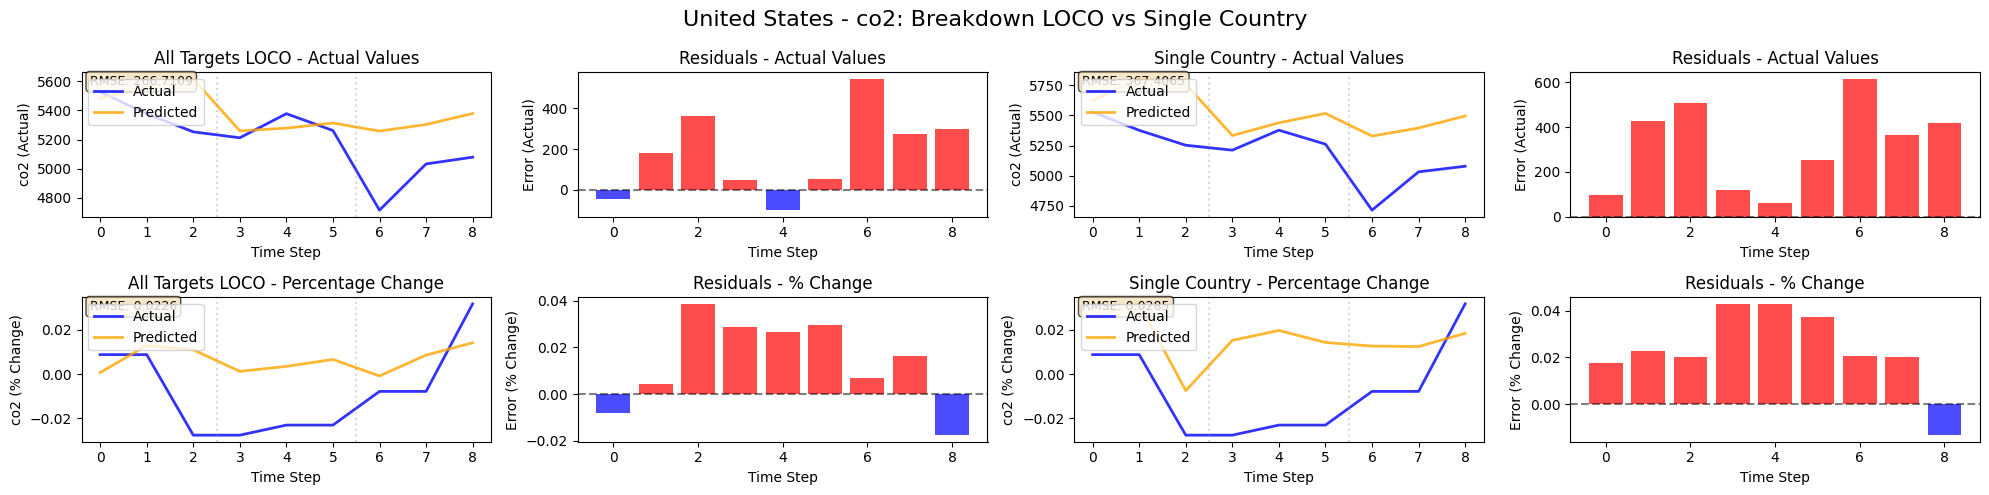


TESTING COUNTRY: Japan

LOCO MODEL
All Targets LOCO for: Japan
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0488, RMSE_actual=64.2280
    Step 2: RMSE_pct=0.0653, RMSE_actual=148.8569
    Step 3: RMSE_pct=0.0797, RMSE_actual=255.7815
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0402, RMSE_actual=48.4120
    Step 2: RMSE_pct=0.0421, RMSE_actual=98.6440
    Step 3: RMSE_pct=0.0194, RMSE_actual=71.4230
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0273, RMSE_actual=30.1812
    Step 2: RMSE_pct=0.3504, RMSE_actual=344.3793
    Step 3: RMSE_pct=0.1814, RMSE_actual=465.0278

SINGLE COUNTRY MODEL

Single Country Model for Japan
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: Us

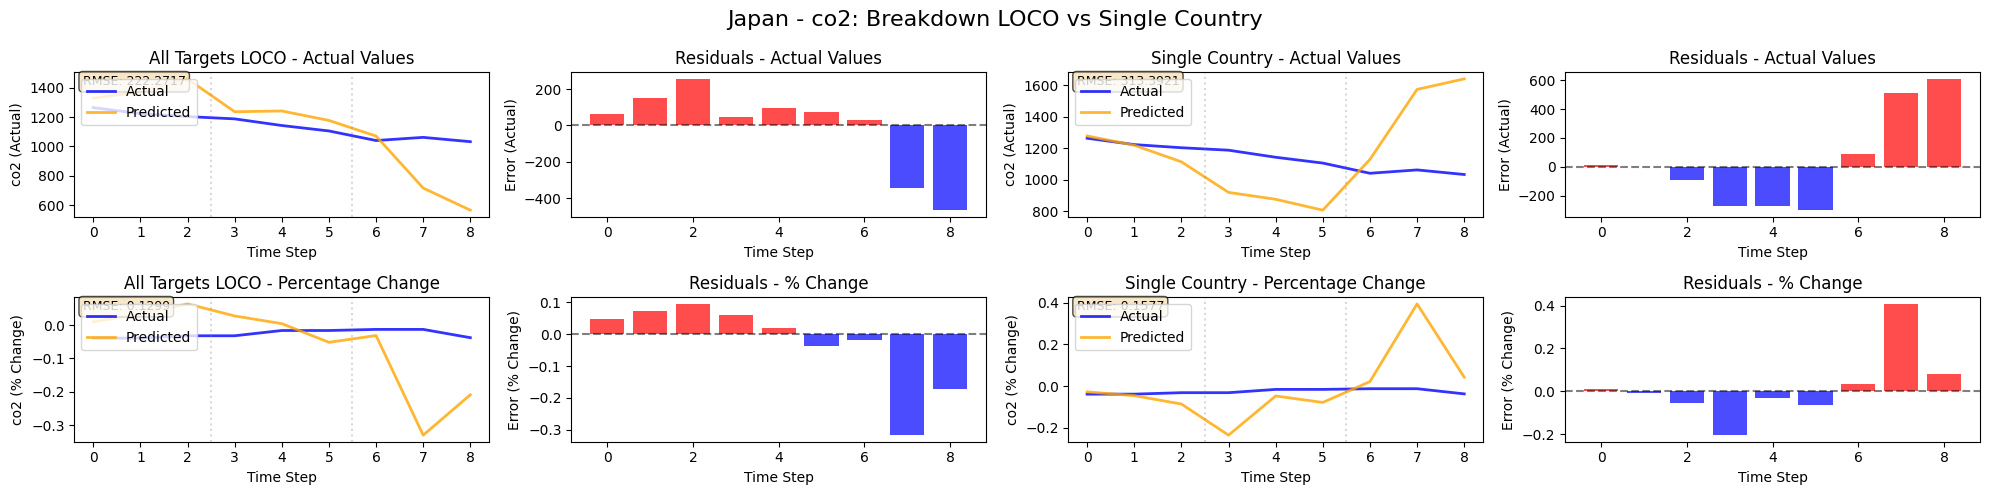


TESTING COUNTRY: Germany

LOCO MODEL
All Targets LOCO for: Germany
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0417, RMSE_actual=34.7087
    Step 2: RMSE_pct=0.0238, RMSE_actual=15.3688
    Step 3: RMSE_pct=0.0212, RMSE_actual=1.9777
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0243, RMSE_actual=19.4296
    Step 2: RMSE_pct=0.0173, RMSE_actual=32.0270
    Step 3: RMSE_pct=0.0486, RMSE_actual=5.4392
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0758, RMSE_actual=53.8030
    Step 2: RMSE_pct=0.0533, RMSE_actual=18.8928
    Step 3: RMSE_pct=0.0127, RMSE_actual=9.8283

SINGLE COUNTRY MODEL

Single Country Model for Germany
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: Usi

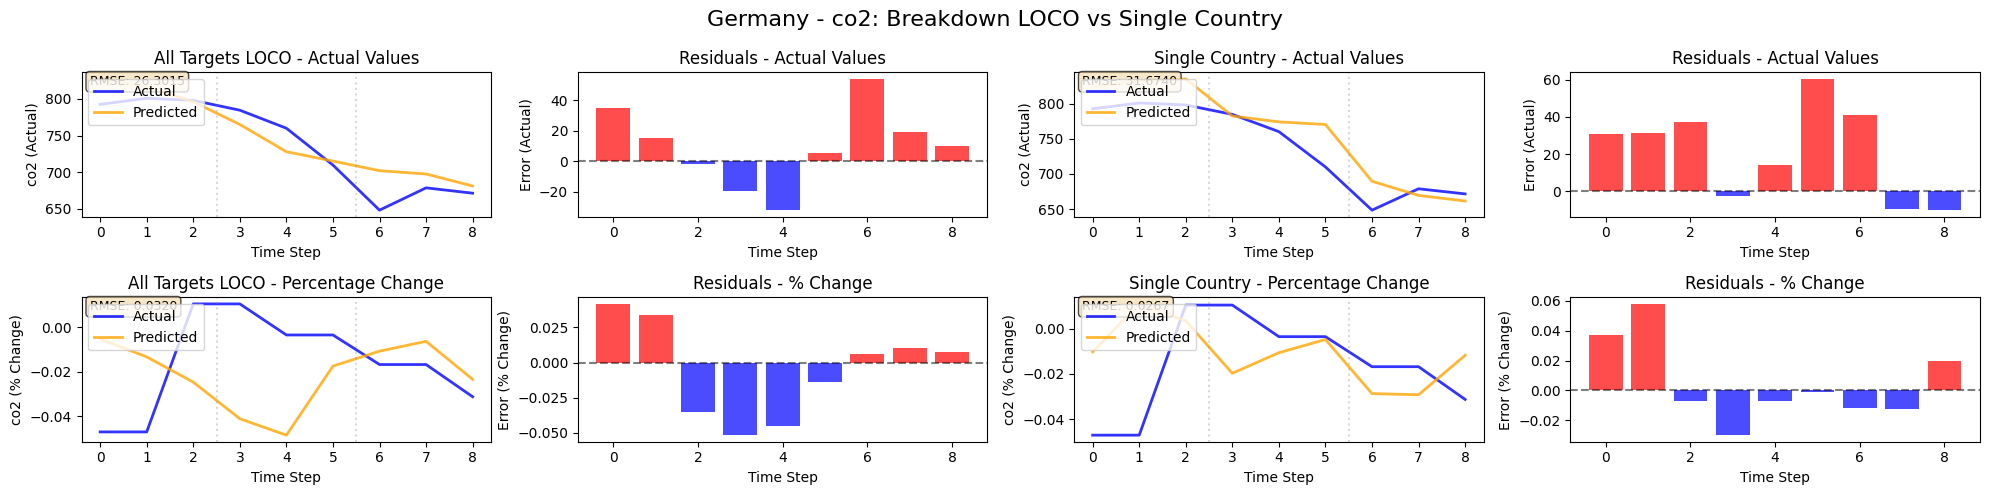


TESTING COUNTRY: United Kingdom

LOCO MODEL
All Targets LOCO for: United Kingdom
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0489, RMSE_actual=23.3367
    Step 2: RMSE_pct=0.0177, RMSE_actual=30.6249
    Step 3: RMSE_pct=0.0351, RMSE_actual=44.8688
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0262, RMSE_actual=10.4779
    Step 2: RMSE_pct=0.0133, RMSE_actual=4.9911
    Step 3: RMSE_pct=0.0105, RMSE_actual=0.7616
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0704, RMSE_actual=25.6833
    Step 2: RMSE_pct=0.0670, RMSE_actual=3.5281
    Step 3: RMSE_pct=0.1042, RMSE_actual=39.4624

SINGLE COUNTRY MODEL

Single Country Model for United Kingdom
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature di

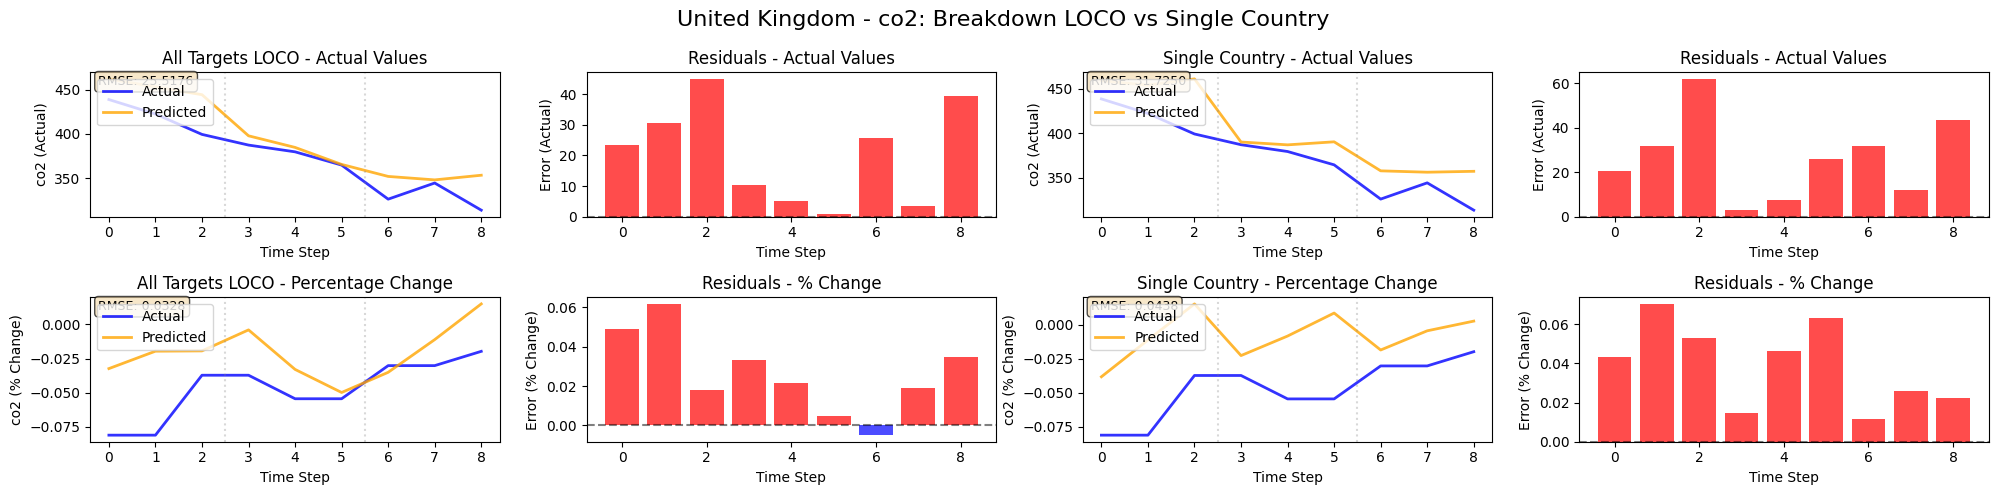


TESTING COUNTRY: France

LOCO MODEL
All Targets LOCO for: France
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.1029, RMSE_actual=36.9139
    Step 2: RMSE_pct=0.0075, RMSE_actual=34.7066
    Step 3: RMSE_pct=0.0269, RMSE_actual=25.1287
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0190, RMSE_actual=6.3380
    Step 2: RMSE_pct=0.0489, RMSE_actual=10.1376
    Step 3: RMSE_pct=0.0348, RMSE_actual=21.4842
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.1025, RMSE_actual=32.3025
    Step 2: RMSE_pct=0.0960, RMSE_actual=5.1667
    Step 3: RMSE_pct=0.0176, RMSE_actual=10.4385

SINGLE COUNTRY MODEL

Single Country Model for France
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: Using

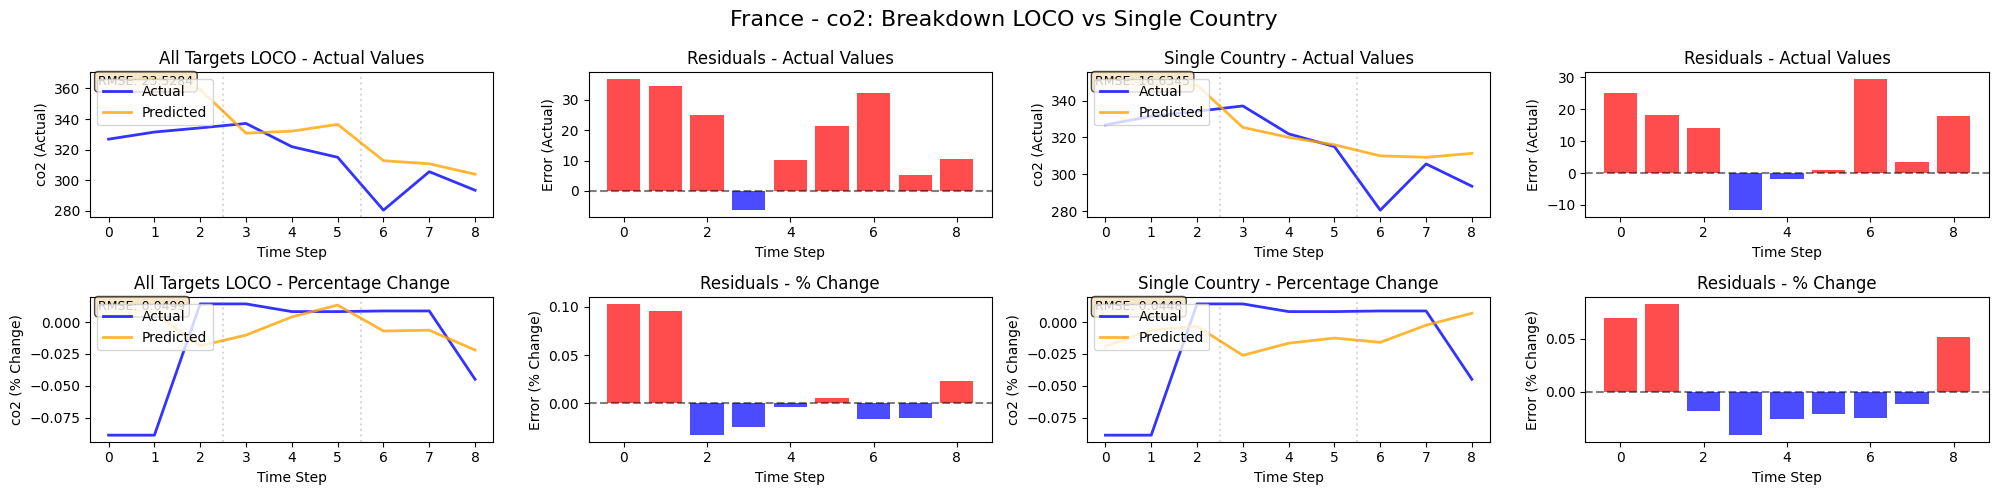


TESTING COUNTRY: Italy

LOCO MODEL
All Targets LOCO for: Italy
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0551, RMSE_actual=20.3409
    Step 2: RMSE_pct=0.0365, RMSE_actual=7.5451
    Step 3: RMSE_pct=0.0078, RMSE_actual=10.3597
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0044, RMSE_actual=1.5917
    Step 2: RMSE_pct=0.0010, RMSE_actual=1.2370
    Step 3: RMSE_pct=0.1399, RMSE_actual=47.4451
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0760, RMSE_actual=25.8062
    Step 2: RMSE_pct=0.1573, RMSE_actual=23.0205
    Step 3: RMSE_pct=0.0878, RMSE_actual=50.8261

SINGLE COUNTRY MODEL

Single Country Model for Italy
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: Using las

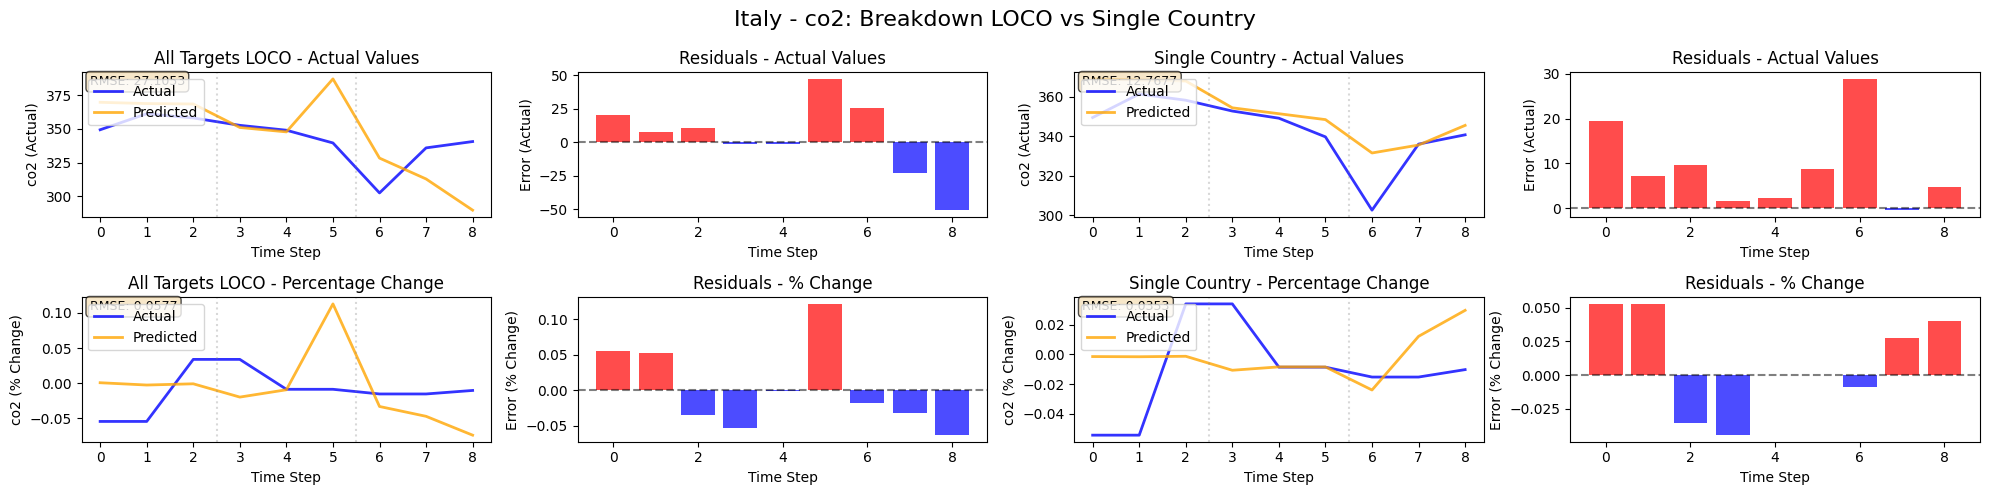


TESTING COUNTRY: Canada

LOCO MODEL
All Targets LOCO for: Canada
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0085, RMSE_actual=4.8247
    Step 2: RMSE_pct=0.0295, RMSE_actual=21.6498
    Step 3: RMSE_pct=0.0401, RMSE_actual=44.9129
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0009, RMSE_actual=0.5029
    Step 2: RMSE_pct=0.0046, RMSE_actual=2.1150
    Step 3: RMSE_pct=0.0066, RMSE_actual=1.6611
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.1018, RMSE_actual=59.2553
    Step 2: RMSE_pct=0.0218, RMSE_actual=48.0222
    Step 3: RMSE_pct=0.0129, RMSE_actual=41.3656

SINGLE COUNTRY MODEL

Single Country Model for Canada
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: Using l

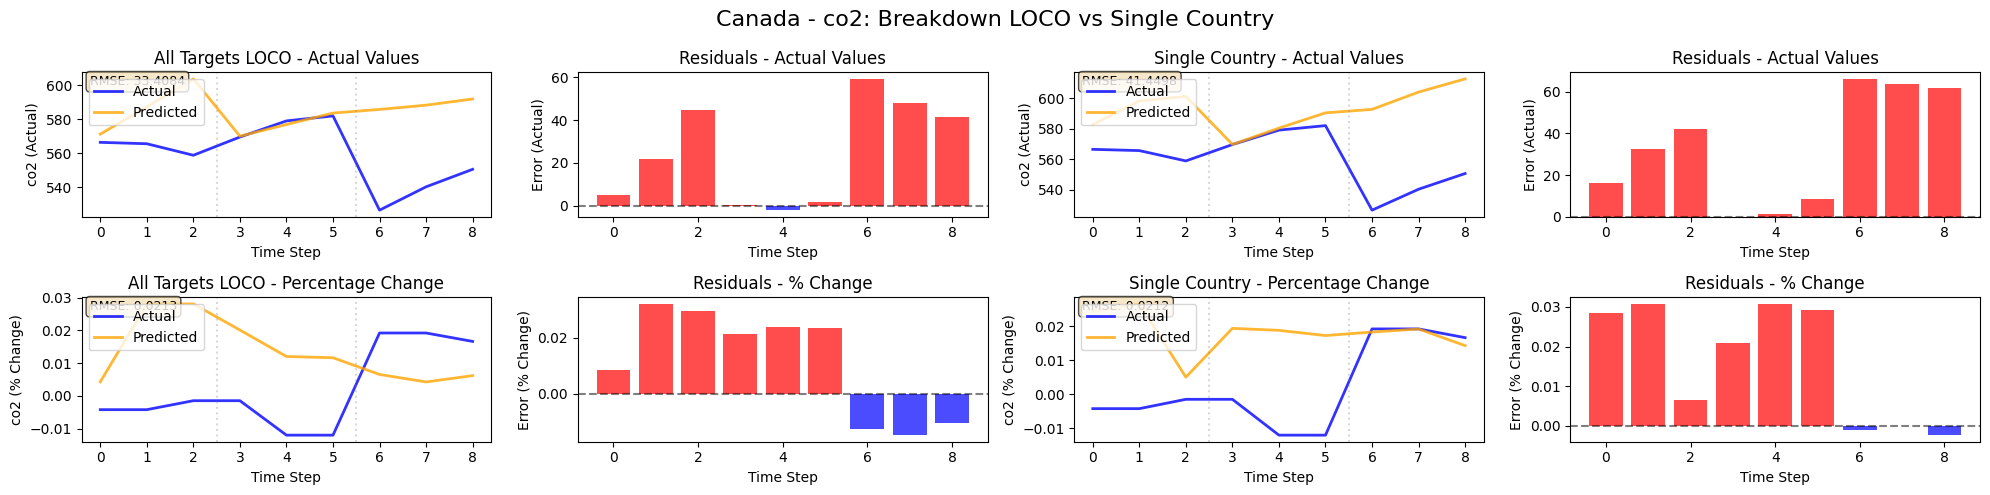


TESTING COUNTRY: Australia

LOCO MODEL
All Targets LOCO for: Australia
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0213, RMSE_actual=8.4858
    Step 2: RMSE_pct=0.0365, RMSE_actual=5.9772
    Step 3: RMSE_pct=0.0633, RMSE_actual=31.1316
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0089, RMSE_actual=3.6411
    Step 2: RMSE_pct=0.0027, RMSE_actual=2.5668
    Step 3: RMSE_pct=0.0261, RMSE_actual=13.3500
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0404, RMSE_actual=16.8012
    Step 2: RMSE_pct=0.0193, RMSE_actual=24.4064
    Step 3: RMSE_pct=0.0067, RMSE_actual=26.8672

SINGLE COUNTRY MODEL

Single Country Model for Australia
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0

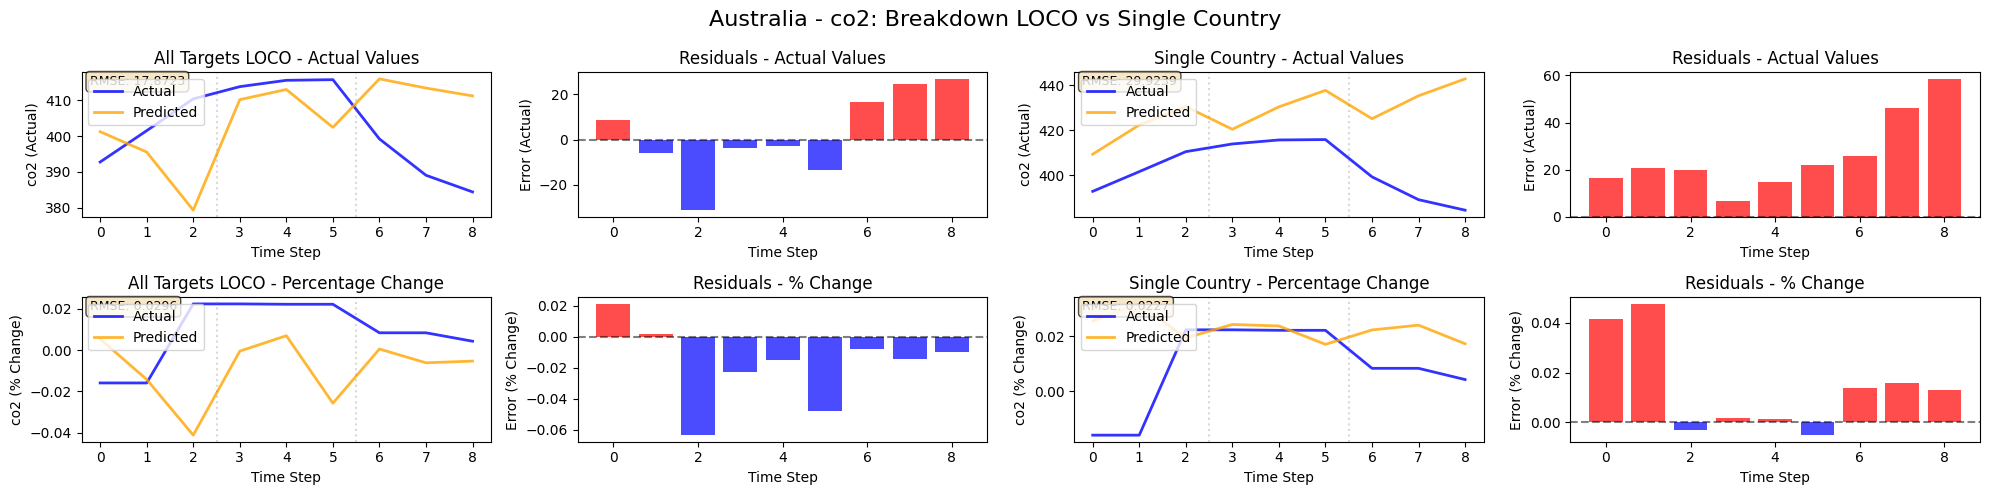


TESTING COUNTRY: South Korea

LOCO MODEL
All Targets LOCO for: South Korea
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 24
Test country test samples: 9
Training seq: 265
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0806, RMSE_actual=51.1696
    Step 2: RMSE_pct=0.0686, RMSE_actual=98.2704
    Step 3: RMSE_pct=0.0585, RMSE_actual=141.6724
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0201, RMSE_actual=12.8522
    Step 2: RMSE_pct=0.0140, RMSE_actual=22.4718
    Step 3: RMSE_pct=0.0664, RMSE_actual=67.6529
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0919, RMSE_actual=59.3451
    Step 2: RMSE_pct=0.0091, RMSE_actual=55.1899
    Step 3: RMSE_pct=0.1034, RMSE_actual=123.3764

SINGLE COUNTRY MODEL

Single Country Model for South Korea
Predicting (co2) and all targets and their lags are used as features
Training samples: 24
Test samples: 9
Number of features: 37
Training seq: 17
Feature dim: 3

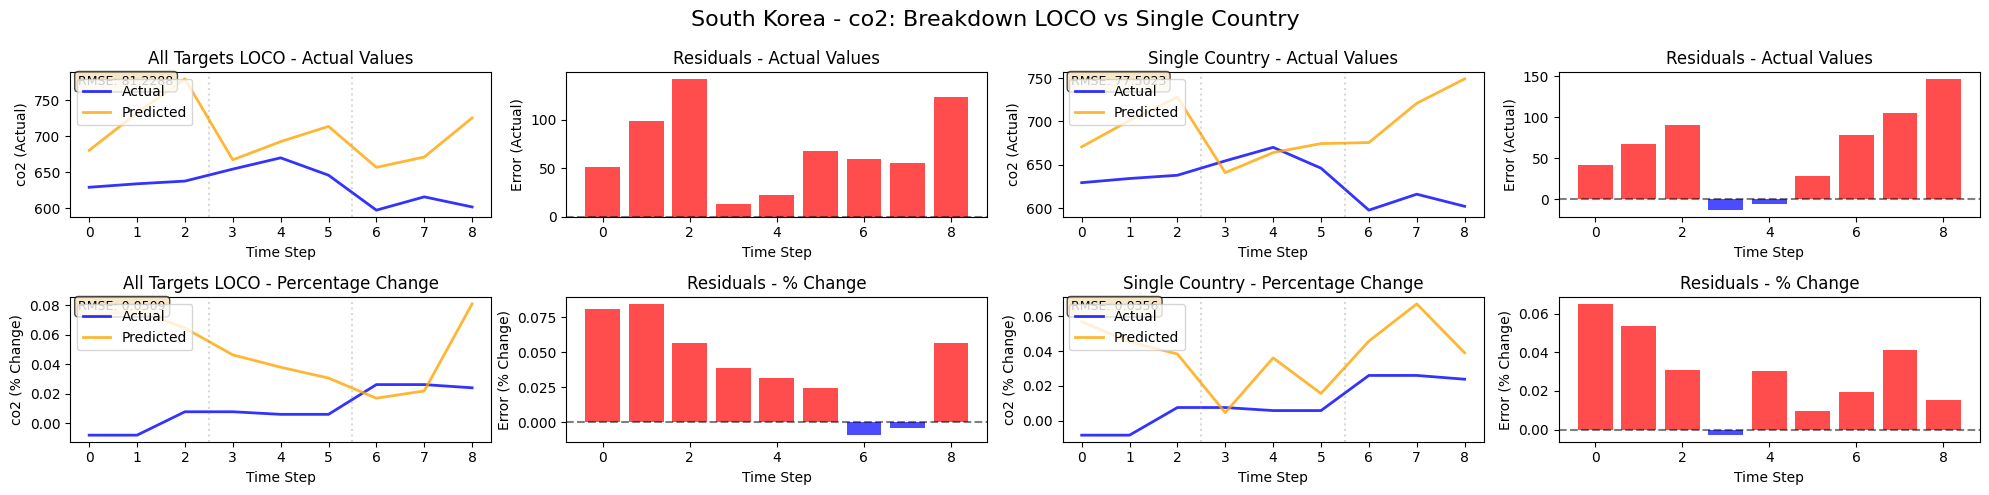


PERFORMANCE SUMMARY



In [117]:
lstm_co2_results, lstm_co2_summary = run_developed_lstm_co2()

In [118]:
def run_developed_bilstm_co2(target='co2', model_func=build_bilstm):
    return run_comparison(
        countries_to_test=DEVELOPED_COUNTRIES,
        target=target,
        model_func=model_func,
        save_dir='data_export/04_results/breakdown/developed',
        country_group='developed'
    )


ENHANCED LOCO vs SINGLE COUNTRY COMPARISON
Experiment: co2_build_bilstm_developed
Target: co2
Model: build_bilstm
Test size: 9 samples
Country group: developed
Data Shape: (1138, 992)

TESTING COUNTRY: United States

LOCO MODEL
All Targets LOCO for: United States
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0063, RMSE_actual=34.5661
    Step 2: RMSE_pct=0.0296, RMSE_actual=198.4695
    Step 3: RMSE_pct=0.0266, RMSE_actual=342.3534
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0197, RMSE_actual=103.6484
    Step 2: RMSE_pct=0.0239, RMSE_actual=20.3395
    Step 3: RMSE_pct=0.0373, RMSE_actual=179.7080
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.1296, RMSE_actual=682.0357
    Step 2: RMSE_pct=0.0461, RMSE_actual=479.1344
    Step 3: RMSE_pct=0.0048, RMSE_actual=510.1283

SINGLE COUNTRY MODEL

Sin

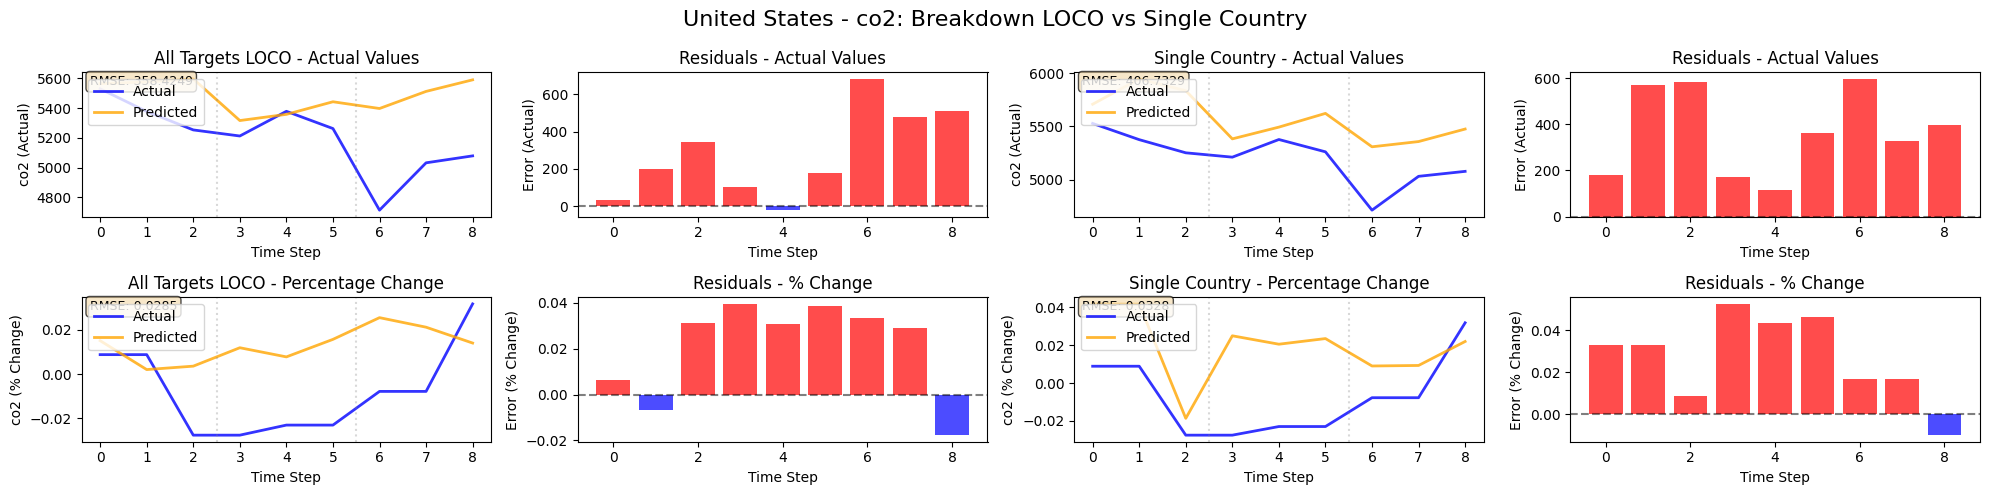


TESTING COUNTRY: Japan

LOCO MODEL
All Targets LOCO for: Japan
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0569, RMSE_actual=74.7798
    Step 2: RMSE_pct=0.1142, RMSE_actual=225.1995
    Step 3: RMSE_pct=0.0089, RMSE_actual=208.5715
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0234, RMSE_actual=28.1111
    Step 2: RMSE_pct=0.0225, RMSE_actual=54.4385
    Step 3: RMSE_pct=0.0840, RMSE_actual=47.8327
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0150, RMSE_actual=16.6175
    Step 2: RMSE_pct=0.1391, RMSE_actual=163.9803
    Step 3: RMSE_pct=0.0655, RMSE_actual=239.7786

SINGLE COUNTRY MODEL

Single Country Model for Japan
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: Us

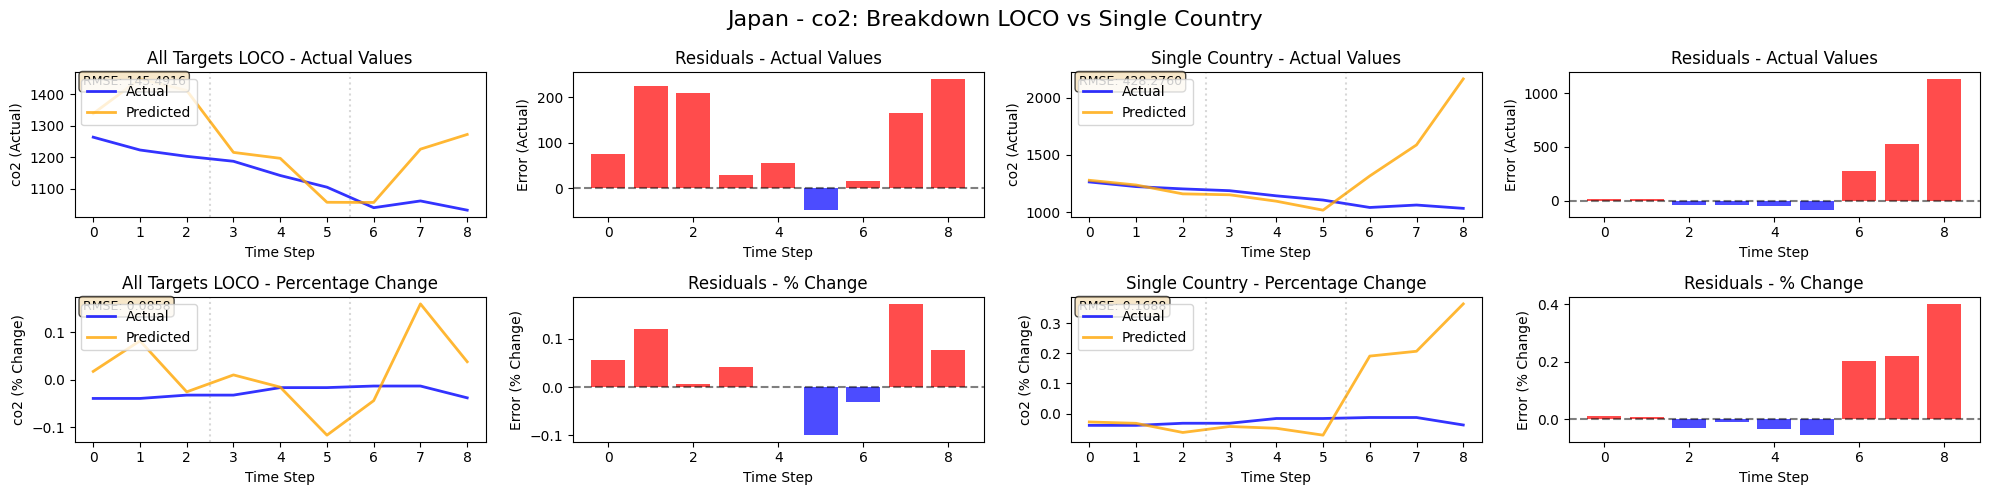


TESTING COUNTRY: Germany

LOCO MODEL
All Targets LOCO for: Germany
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0915, RMSE_actual=76.0922
    Step 2: RMSE_pct=0.0355, RMSE_actual=46.0155
    Step 3: RMSE_pct=0.0338, RMSE_actual=17.2001
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0486, RMSE_actual=38.7667
    Step 2: RMSE_pct=0.0497, RMSE_actual=3.3493
    Step 3: RMSE_pct=0.0539, RMSE_actual=37.6765
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0908, RMSE_actual=64.4276
    Step 2: RMSE_pct=0.0770, RMSE_actual=12.5932
    Step 3: RMSE_pct=0.0338, RMSE_actual=10.9307

SINGLE COUNTRY MODEL

Single Country Model for Germany
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: U

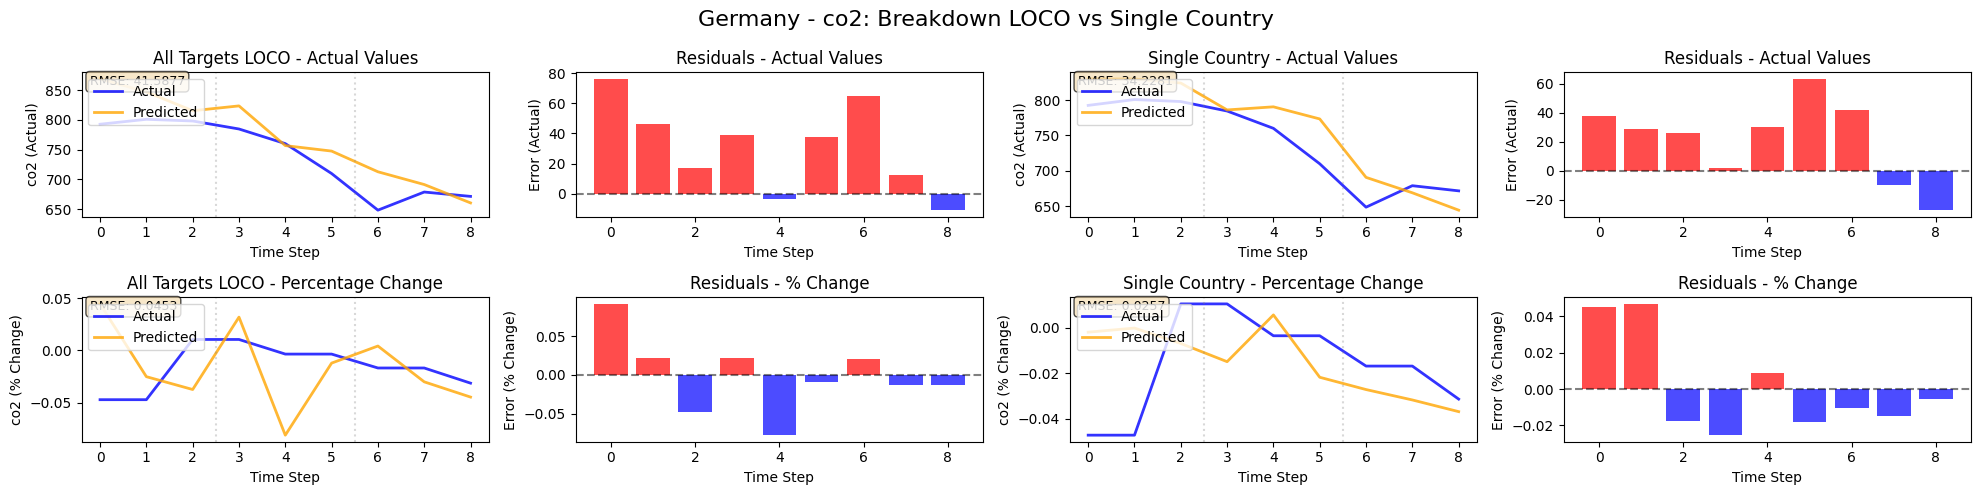


TESTING COUNTRY: United Kingdom

LOCO MODEL
All Targets LOCO for: United Kingdom
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0595, RMSE_actual=28.3958
    Step 2: RMSE_pct=0.0743, RMSE_actual=62.0513
    Step 3: RMSE_pct=0.1182, RMSE_actual=115.9173
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0842, RMSE_actual=33.6376
    Step 2: RMSE_pct=0.0665, RMSE_actual=60.9915
    Step 3: RMSE_pct=0.0314, RMSE_actual=72.4212
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0640, RMSE_actual=23.3422
    Step 2: RMSE_pct=0.0283, RMSE_actual=14.7373
    Step 3: RMSE_pct=0.1147, RMSE_actual=54.6213

SINGLE COUNTRY MODEL

Single Country Model for United Kingdom
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Featur

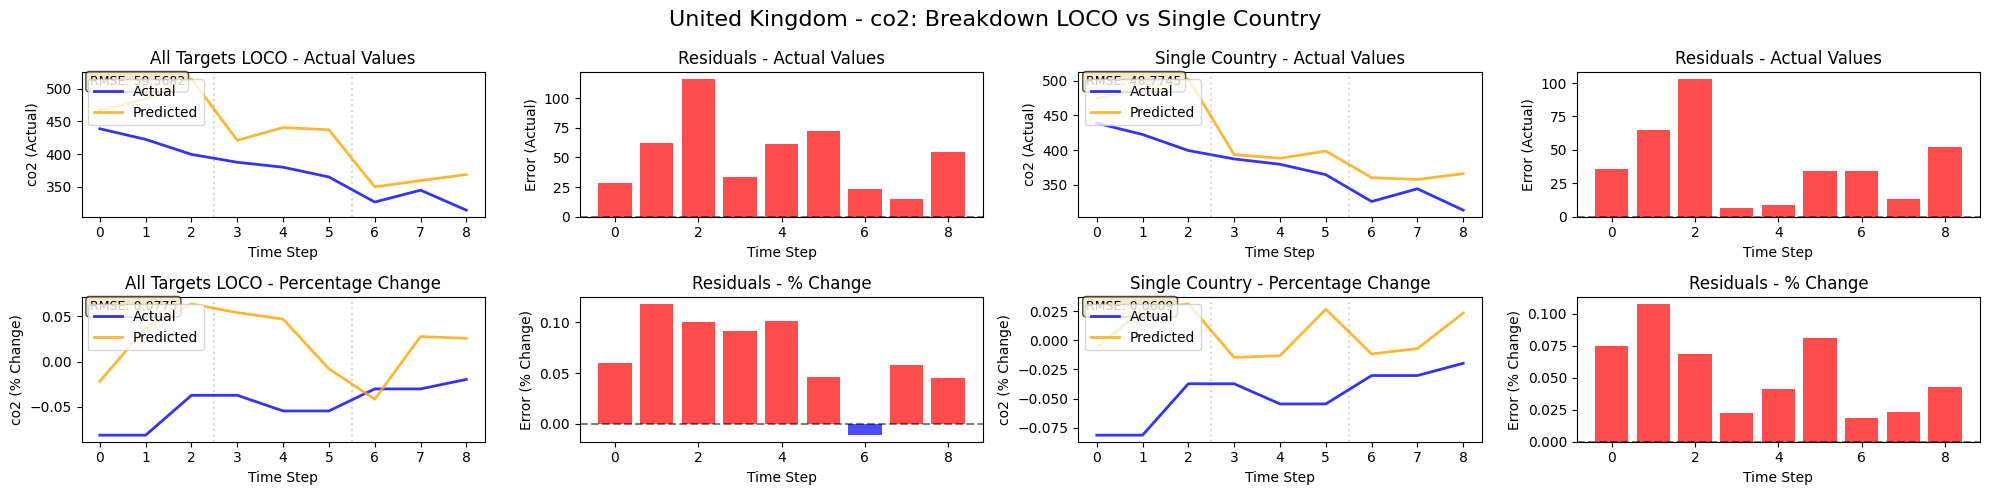


TESTING COUNTRY: France

LOCO MODEL
All Targets LOCO for: France
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.1076, RMSE_actual=38.5829
    Step 2: RMSE_pct=0.0044, RMSE_actual=40.7226
    Step 3: RMSE_pct=0.0068, RMSE_actual=38.5255
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0401, RMSE_actual=13.3865
    Step 2: RMSE_pct=0.0637, RMSE_actual=7.8491
    Step 3: RMSE_pct=0.0811, RMSE_actual=34.4393
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0833, RMSE_actual=26.2407
    Step 2: RMSE_pct=0.1081, RMSE_actual=4.5667
    Step 3: RMSE_pct=0.0152, RMSE_actual=8.9569

SINGLE COUNTRY MODEL

Single Country Model for France
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: Using 

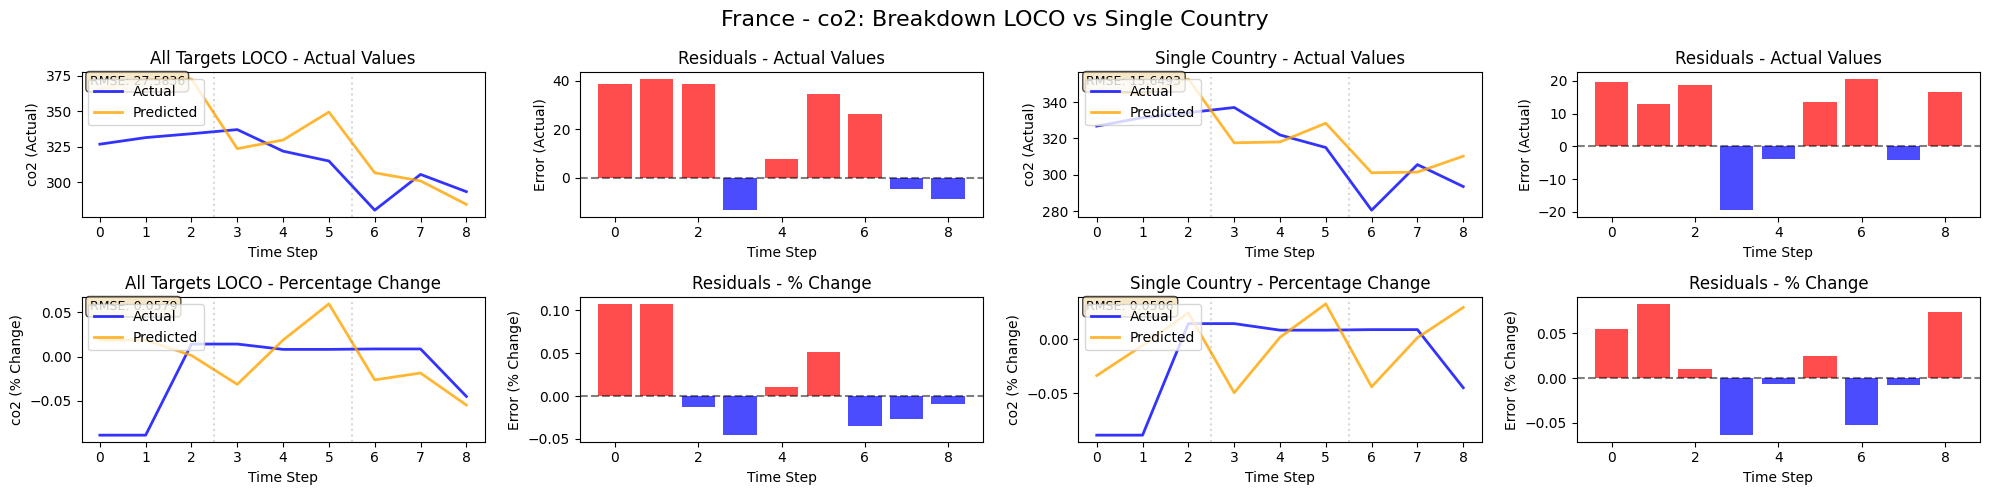


TESTING COUNTRY: Italy

LOCO MODEL
All Targets LOCO for: Italy
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0352, RMSE_actual=13.0003
    Step 2: RMSE_pct=0.0597, RMSE_actual=8.1766
    Step 3: RMSE_pct=0.0108, RMSE_actual=4.3073
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0752, RMSE_actual=26.9251
    Step 2: RMSE_pct=0.0134, RMSE_actual=21.5766
    Step 3: RMSE_pct=0.0012, RMSE_actual=20.5473
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.1285, RMSE_actual=43.6262
    Step 2: RMSE_pct=0.1362, RMSE_actual=1.2703
    Step 3: RMSE_pct=0.0174, RMSE_actual=4.5966

SINGLE COUNTRY MODEL

Single Country Model for Italy
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: Using last

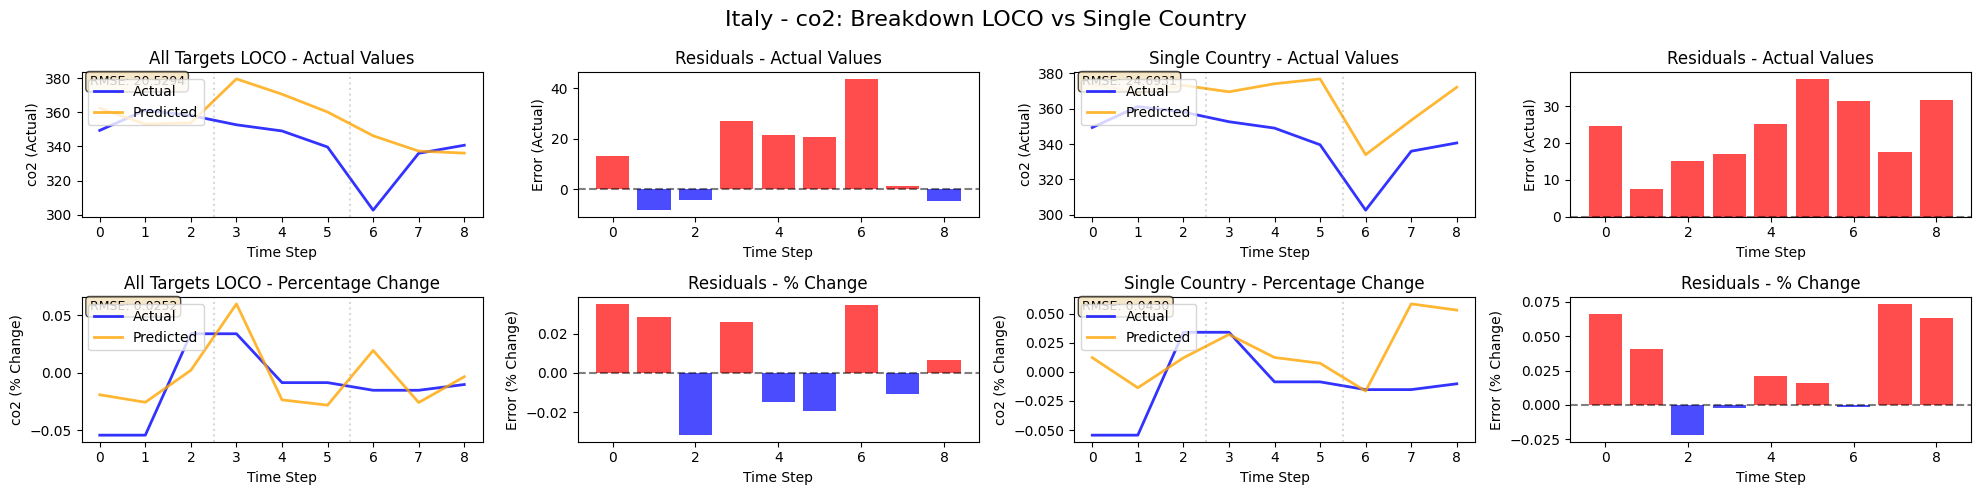


TESTING COUNTRY: Canada

LOCO MODEL
All Targets LOCO for: Canada
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0146, RMSE_actual=8.3137
    Step 2: RMSE_pct=0.0292, RMSE_actual=25.0635
    Step 3: RMSE_pct=0.0409, RMSE_actual=48.9512
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0036, RMSE_actual=1.9847
    Step 2: RMSE_pct=0.0086, RMSE_actual=6.9018
    Step 3: RMSE_pct=0.0040, RMSE_actual=9.1998
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0946, RMSE_actual=55.0873
    Step 2: RMSE_pct=0.0281, RMSE_actual=40.1858
    Step 3: RMSE_pct=0.0143, RMSE_actual=32.6738

SINGLE COUNTRY MODEL

Single Country Model for Canada
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: Using l

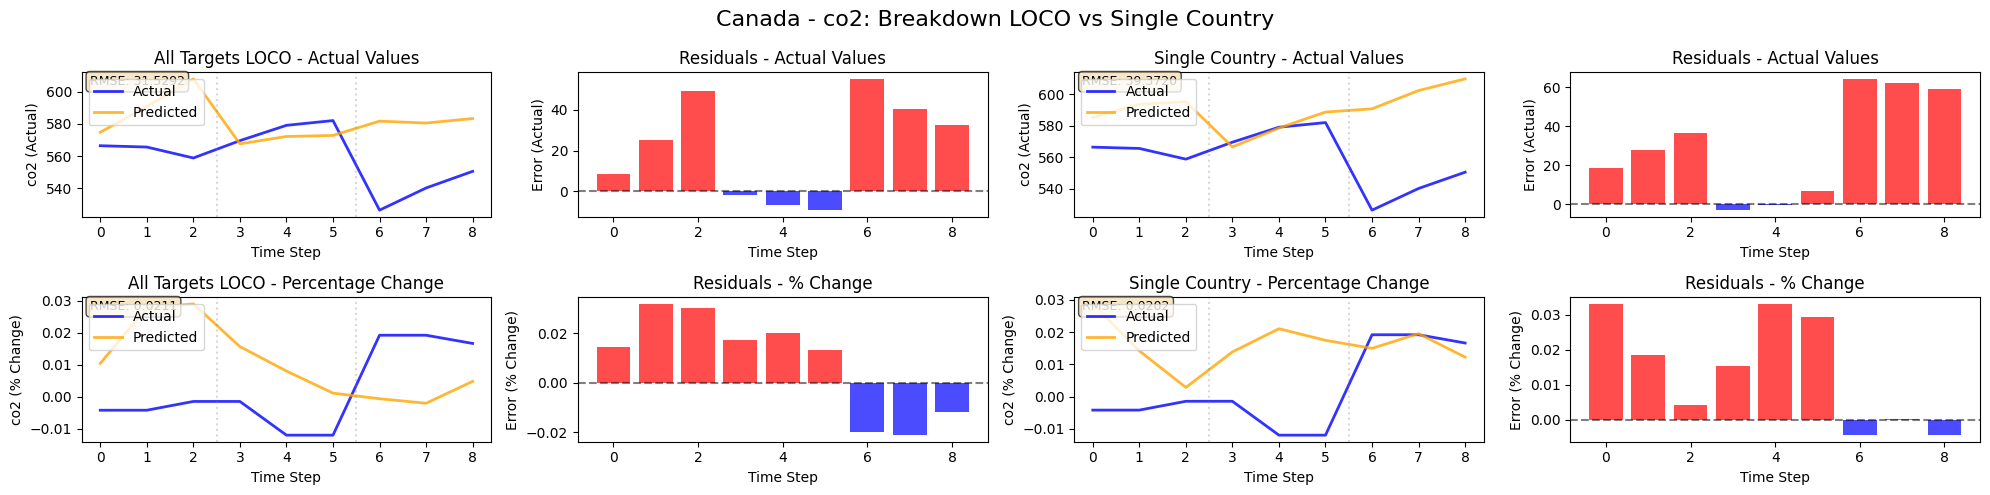


TESTING COUNTRY: Australia

LOCO MODEL
All Targets LOCO for: Australia
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0033, RMSE_actual=1.3031
    Step 2: RMSE_pct=0.0225, RMSE_actual=10.1484
    Step 3: RMSE_pct=0.0121, RMSE_actual=5.6542
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0142, RMSE_actual=5.8480
    Step 2: RMSE_pct=0.0357, RMSE_actual=20.8565
    Step 3: RMSE_pct=0.0103, RMSE_actual=16.3716
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0713, RMSE_actual=29.6484
    Step 2: RMSE_pct=0.0495, RMSE_actual=50.1166
    Step 3: RMSE_pct=0.0117, RMSE_actual=54.6679

SINGLE COUNTRY MODEL

Single Country Model for Australia
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 

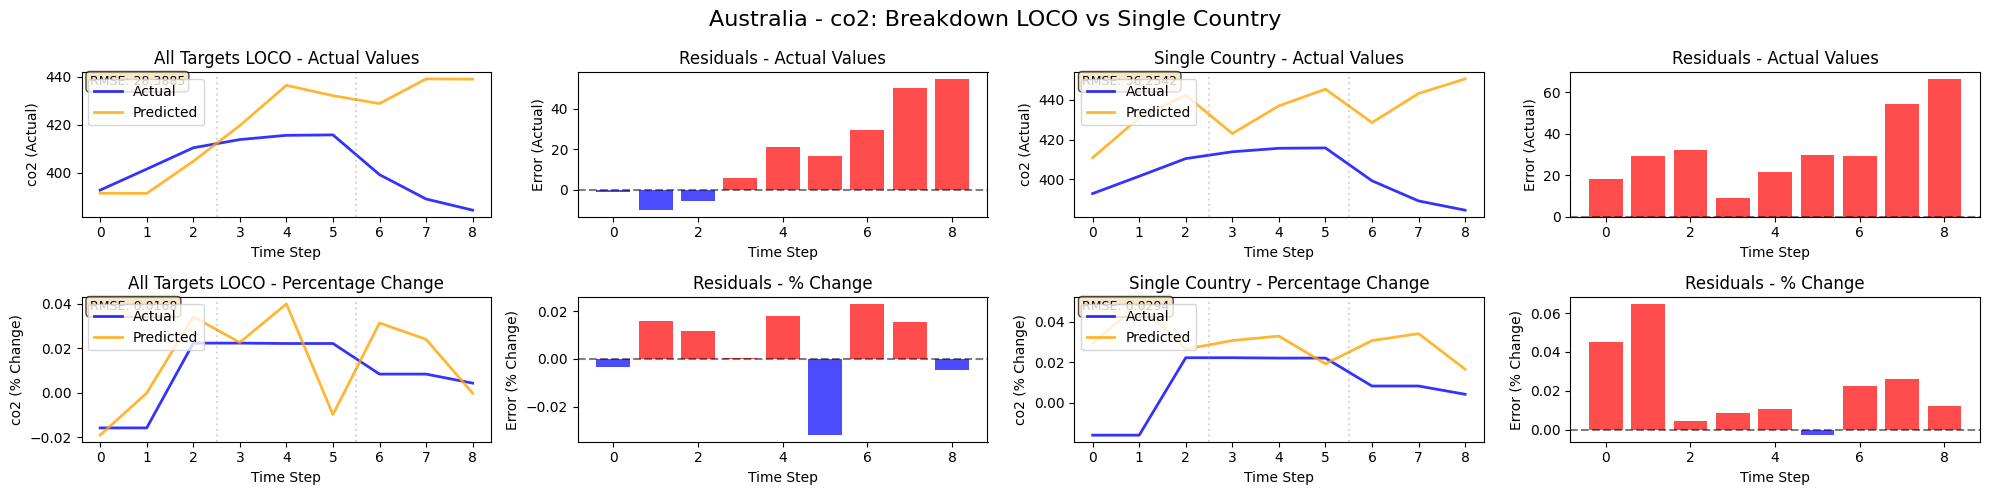


TESTING COUNTRY: South Korea

LOCO MODEL
All Targets LOCO for: South Korea
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 24
Test country test samples: 9
Training seq: 265
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0807, RMSE_actual=51.2195
    Step 2: RMSE_pct=0.0379, RMSE_actual=77.4261
    Step 3: RMSE_pct=0.0242, RMSE_actual=95.1172
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0336, RMSE_actual=21.4452
    Step 2: RMSE_pct=0.0253, RMSE_actual=39.0634
    Step 3: RMSE_pct=0.0588, RMSE_actual=79.3967
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0974, RMSE_actual=62.9326
    Step 2: RMSE_pct=0.0035, RMSE_actual=62.5744
    Step 3: RMSE_pct=0.0533, RMSE_actual=97.3525

SINGLE COUNTRY MODEL

Single Country Model for South Korea
Predicting (co2) and all targets and their lags are used as features
Training samples: 24
Test samples: 9
Number of features: 37
Training seq: 17
Feature dim: 37


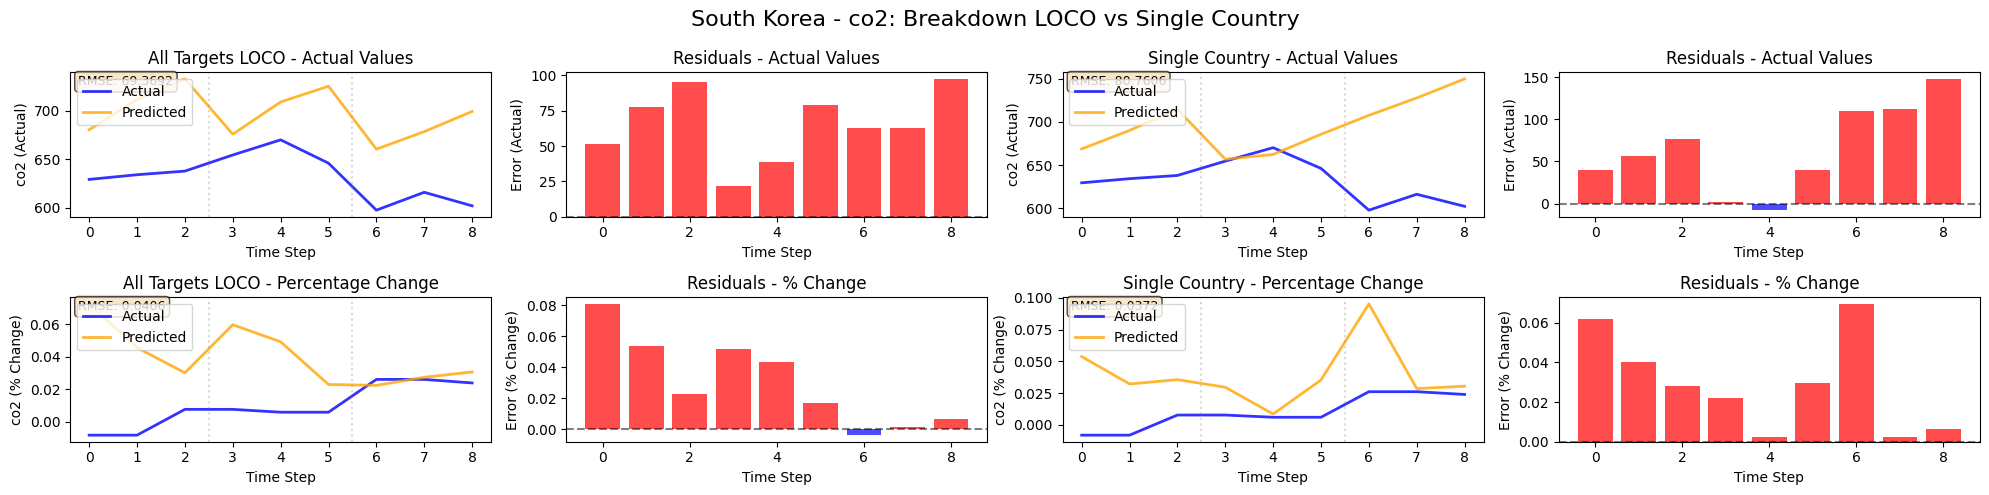


PERFORMANCE SUMMARY


In [119]:
bilstm_co2_results, bilstm_co2_summary = run_developed_bilstm_co2()

In [120]:
def run_developed_edlstm_co2(target='co2', model_func=build_edlstm):
    return run_comparison(
        countries_to_test=DEVELOPED_COUNTRIES,
        target=target,
        model_func=model_func,
        save_dir='data_export/04_results/breakdown/developed',
        country_group='developed'
    )


ENHANCED LOCO vs SINGLE COUNTRY COMPARISON
Experiment: co2_build_bilstm_developed
Target: co2
Model: build_bilstm
Test size: 9 samples
Country group: developed
Data Shape: (1138, 992)

TESTING COUNTRY: United States

LOCO MODEL
All Targets LOCO for: United States
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0132, RMSE_actual=72.2383
    Step 2: RMSE_pct=0.0533, RMSE_actual=220.4337
    Step 3: RMSE_pct=0.0307, RMSE_actual=387.3662
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0081, RMSE_actual=42.6749
    Step 2: RMSE_pct=0.0288, RMSE_actual=107.5375
    Step 3: RMSE_pct=0.0370, RMSE_actual=89.5859
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.1368, RMSE_actual=719.7833
    Step 2: RMSE_pct=0.0582, RMSE_actual=452.2440
    Step 3: RMSE_pct=0.0220, RMSE_actual=335.7858

SINGLE COUNTRY MODEL

Sing

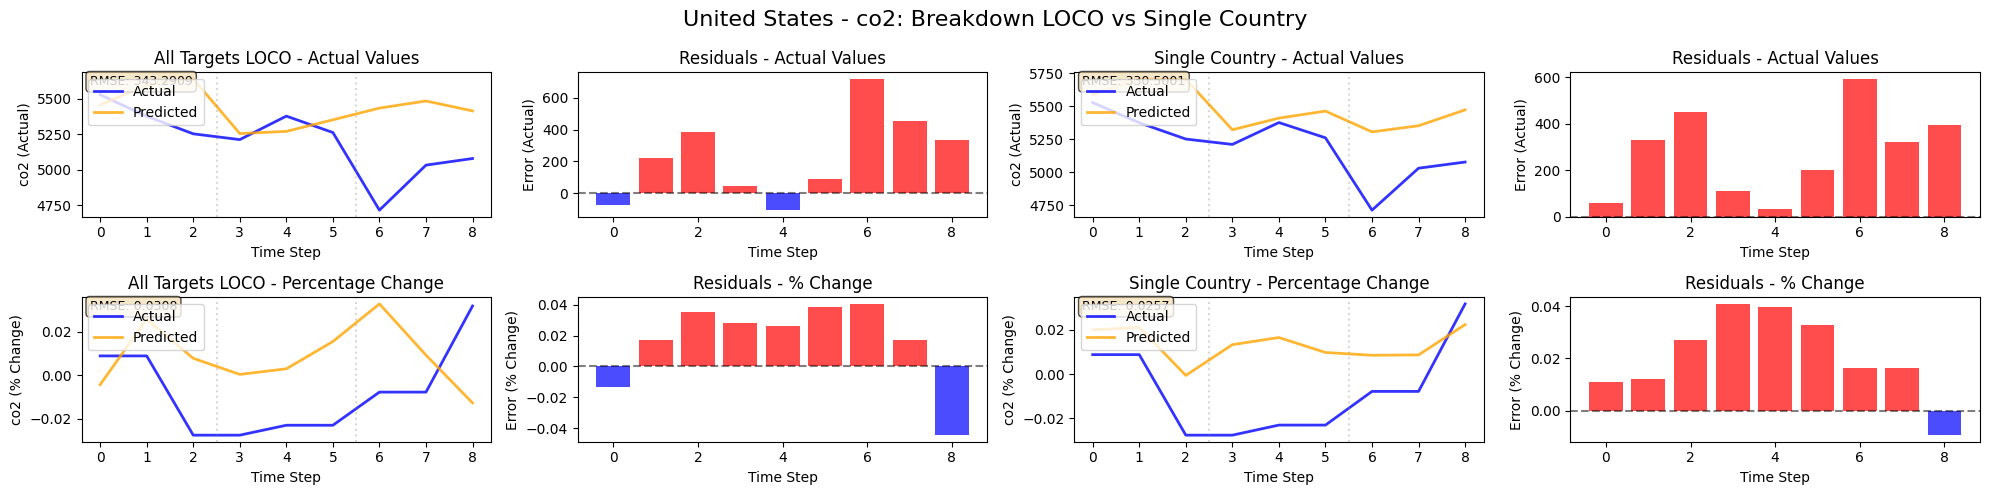


TESTING COUNTRY: Japan

LOCO MODEL
All Targets LOCO for: Japan
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0490, RMSE_actual=64.4766
    Step 2: RMSE_pct=0.1336, RMSE_actual=239.8658
    Step 3: RMSE_pct=0.1286, RMSE_actual=424.0901
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.1417, RMSE_actual=170.5440
    Step 2: RMSE_pct=0.0962, RMSE_actual=261.9401
    Step 3: RMSE_pct=0.0848, RMSE_actual=328.1040
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.1190, RMSE_actual=131.5733
    Step 2: RMSE_pct=0.1372, RMSE_actual=295.0407
    Step 3: RMSE_pct=0.0888, RMSE_actual=166.3707

SINGLE COUNTRY MODEL

Single Country Model for Japan
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0

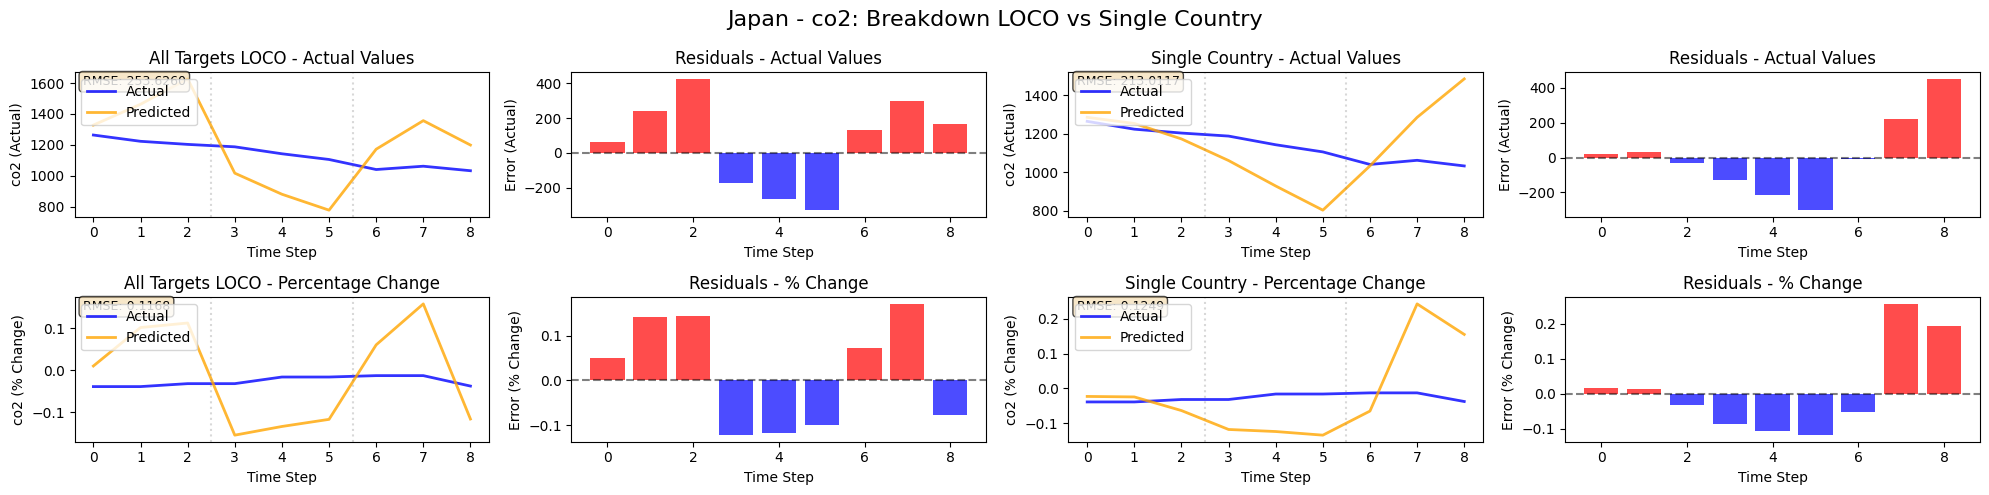


TESTING COUNTRY: Germany

LOCO MODEL
All Targets LOCO for: Germany
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.1289, RMSE_actual=107.2273
    Step 2: RMSE_pct=0.0230, RMSE_actual=87.6523
    Step 3: RMSE_pct=0.0096, RMSE_actual=78.7708
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0108, RMSE_actual=8.5976
    Step 2: RMSE_pct=0.0075, RMSE_actual=14.2738
    Step 3: RMSE_pct=0.0695, RMSE_actual=67.1832
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0778, RMSE_actual=55.2013
    Step 2: RMSE_pct=0.0857, RMSE_actual=2.5198
    Step 3: RMSE_pct=0.0248, RMSE_actual=19.2584

SINGLE COUNTRY MODEL

Single Country Model for Germany
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: U

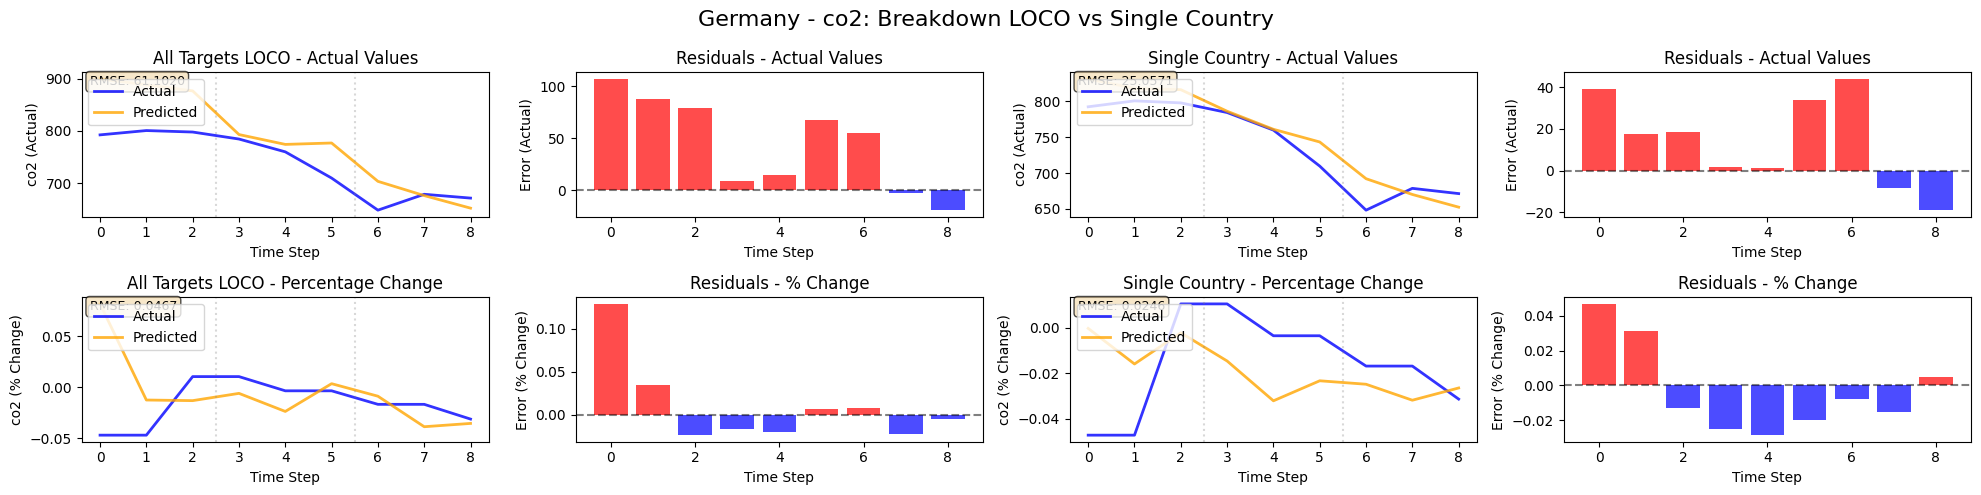


TESTING COUNTRY: United Kingdom

LOCO MODEL
All Targets LOCO for: United Kingdom
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0413, RMSE_actual=19.7170
    Step 2: RMSE_pct=0.0531, RMSE_actual=3.2659
    Step 3: RMSE_pct=0.0880, RMSE_actual=40.5578
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0350, RMSE_actual=13.9895
    Step 2: RMSE_pct=0.0357, RMSE_actual=28.0520
    Step 3: RMSE_pct=0.0145, RMSE_actual=32.8443
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0142, RMSE_actual=5.1782
    Step 2: RMSE_pct=0.0345, RMSE_actual=5.9633
    Step 3: RMSE_pct=0.1471, RMSE_actual=44.3716

SINGLE COUNTRY MODEL

Single Country Model for United Kingdom
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature di

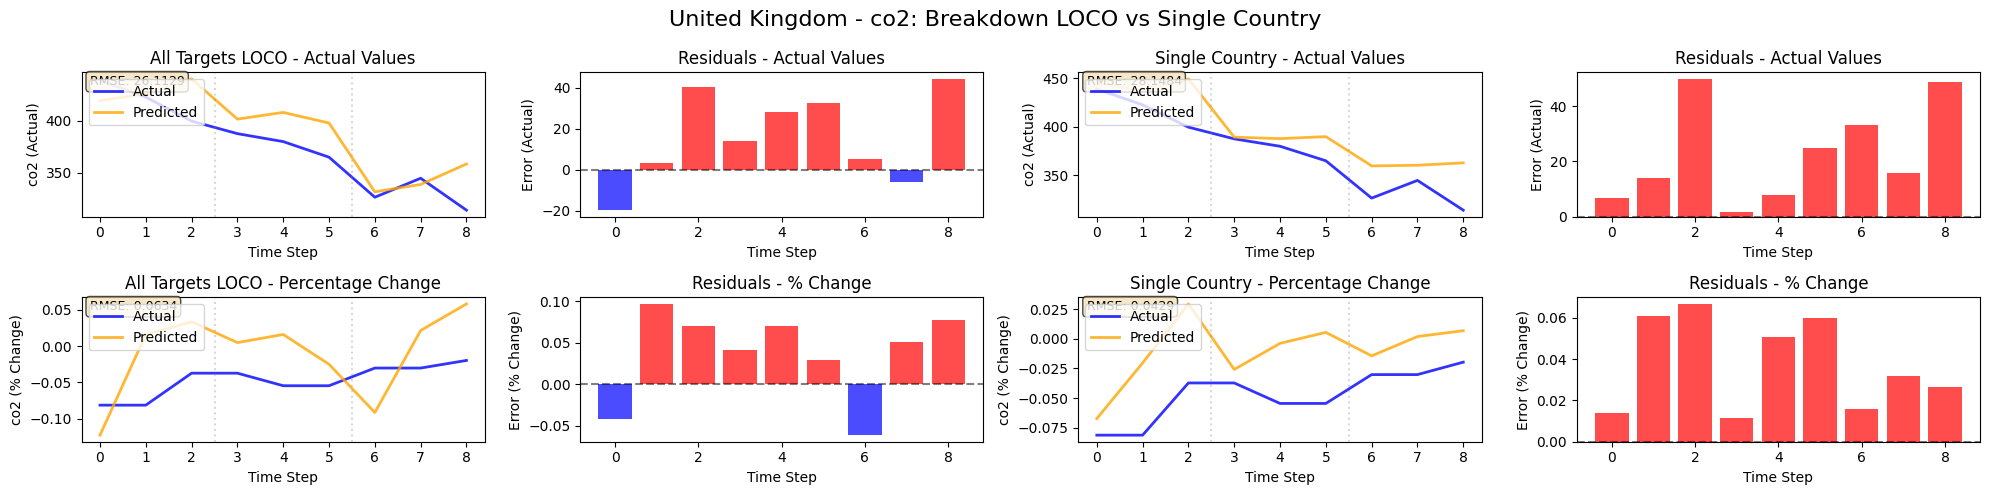


TESTING COUNTRY: France

LOCO MODEL
All Targets LOCO for: France
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.1053, RMSE_actual=37.7876
    Step 2: RMSE_pct=0.0095, RMSE_actual=34.8715
    Step 3: RMSE_pct=0.0320, RMSE_actual=23.4479
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0304, RMSE_actual=10.1586
    Step 2: RMSE_pct=0.0157, RMSE_actual=4.5758
    Step 3: RMSE_pct=0.0225, RMSE_actual=2.6792
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0876, RMSE_actual=27.5910
    Step 2: RMSE_pct=0.1028, RMSE_actual=1.6006
    Step 3: RMSE_pct=0.0160, RMSE_actual=6.4095

SINGLE COUNTRY MODEL

Single Country Model for France
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: Using l

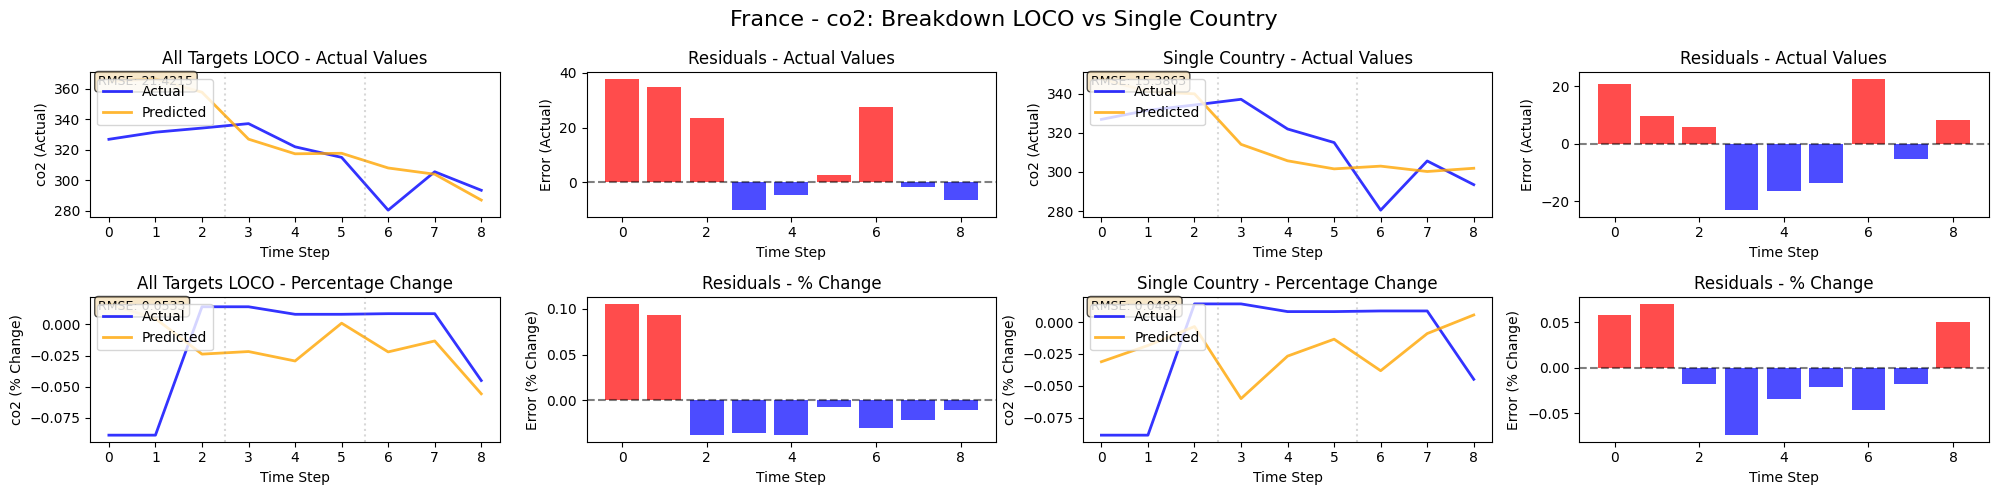


TESTING COUNTRY: Italy

LOCO MODEL
All Targets LOCO for: Italy
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0897, RMSE_actual=33.1268
    Step 2: RMSE_pct=0.0371, RMSE_actual=20.0695
    Step 3: RMSE_pct=0.0074, RMSE_actual=22.7174
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.1072, RMSE_actual=38.4043
    Step 2: RMSE_pct=0.0244, RMSE_actual=47.5480
    Step 3: RMSE_pct=0.0861, RMSE_actual=80.4235
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.1486, RMSE_actual=50.4694
    Step 2: RMSE_pct=0.1256, RMSE_actual=11.6919
    Step 3: RMSE_pct=0.0259, RMSE_actual=2.8632

SINGLE COUNTRY MODEL

Single Country Model for Italy
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: Using l

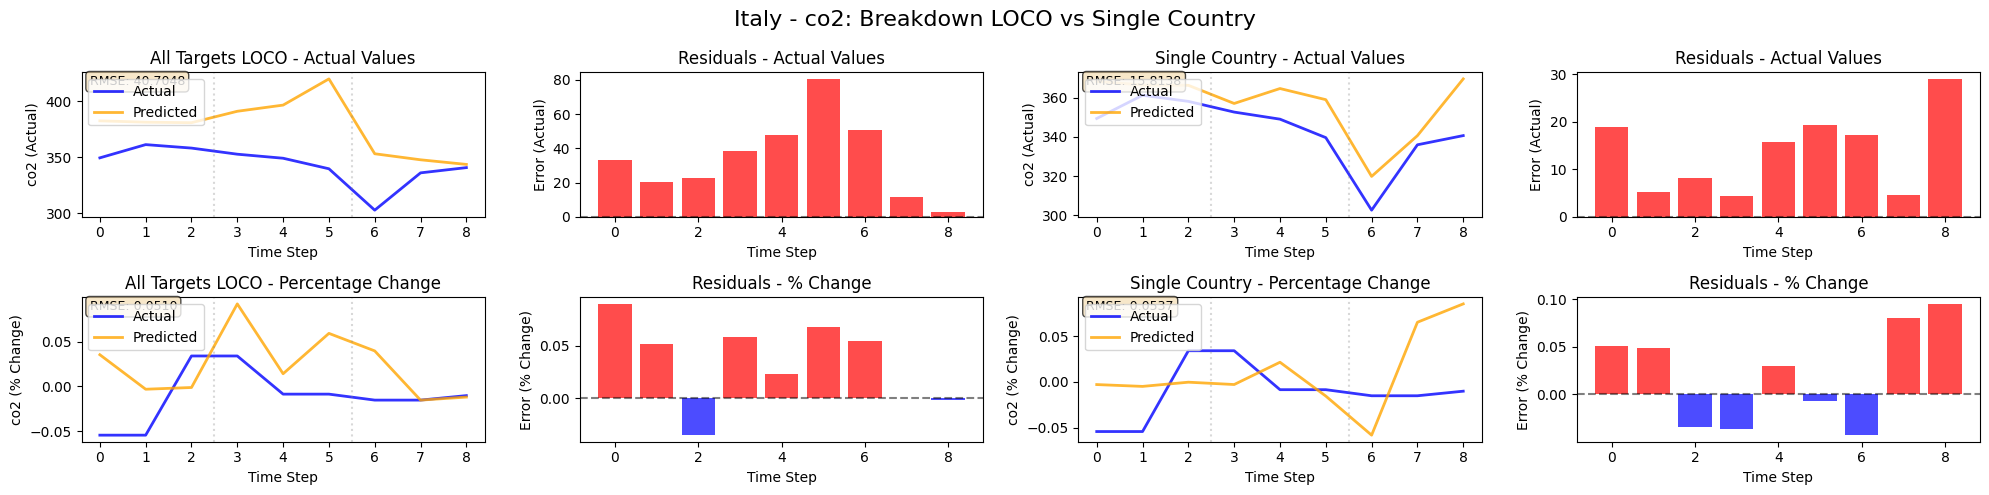


TESTING COUNTRY: Canada

LOCO MODEL
All Targets LOCO for: Canada
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0264, RMSE_actual=15.0407
    Step 2: RMSE_pct=0.0111, RMSE_actual=21.5015
    Step 3: RMSE_pct=0.0137, RMSE_actual=29.2928
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0142, RMSE_actual=7.9275
    Step 2: RMSE_pct=0.0189, RMSE_actual=18.6527
    Step 3: RMSE_pct=0.0068, RMSE_actual=14.9096
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.1089, RMSE_actual=63.3852
    Step 2: RMSE_pct=0.0201, RMSE_actual=53.2079
    Step 3: RMSE_pct=0.0116, RMSE_actual=47.3548

SINGLE COUNTRY MODEL

Single Country Model for Canada
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Iter 0: Usin

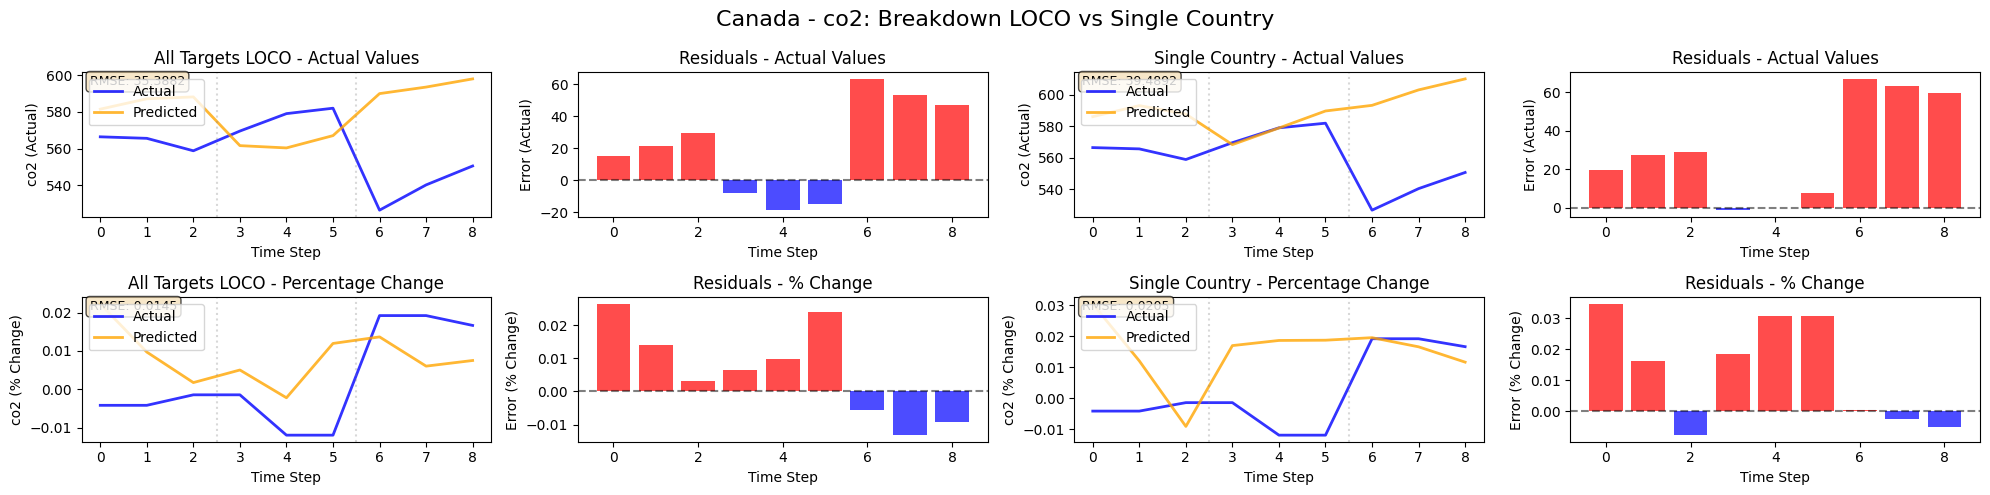


TESTING COUNTRY: Australia

LOCO MODEL
All Targets LOCO for: Australia
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 25
Test country test samples: 9
Training seq: 264
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.0216, RMSE_actual=8.6093
    Step 2: RMSE_pct=0.0167, RMSE_actual=15.2017
    Step 3: RMSE_pct=0.0055, RMSE_actual=17.6644
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0438, RMSE_actual=17.9572
    Step 2: RMSE_pct=0.0223, RMSE_actual=26.8499
    Step 3: RMSE_pct=0.0593, RMSE_actual=49.8996
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0418, RMSE_actual=17.3925
    Step 2: RMSE_pct=0.0436, RMSE_actual=35.0918
    Step 3: RMSE_pct=0.0249, RMSE_actual=45.2386

SINGLE COUNTRY MODEL

Single Country Model for Australia
Predicting (co2) and all targets and their lags are used as features
Training samples: 25
Test samples: 9
Number of features: 37
Training seq: 18
Feature dim: 37
    Ite

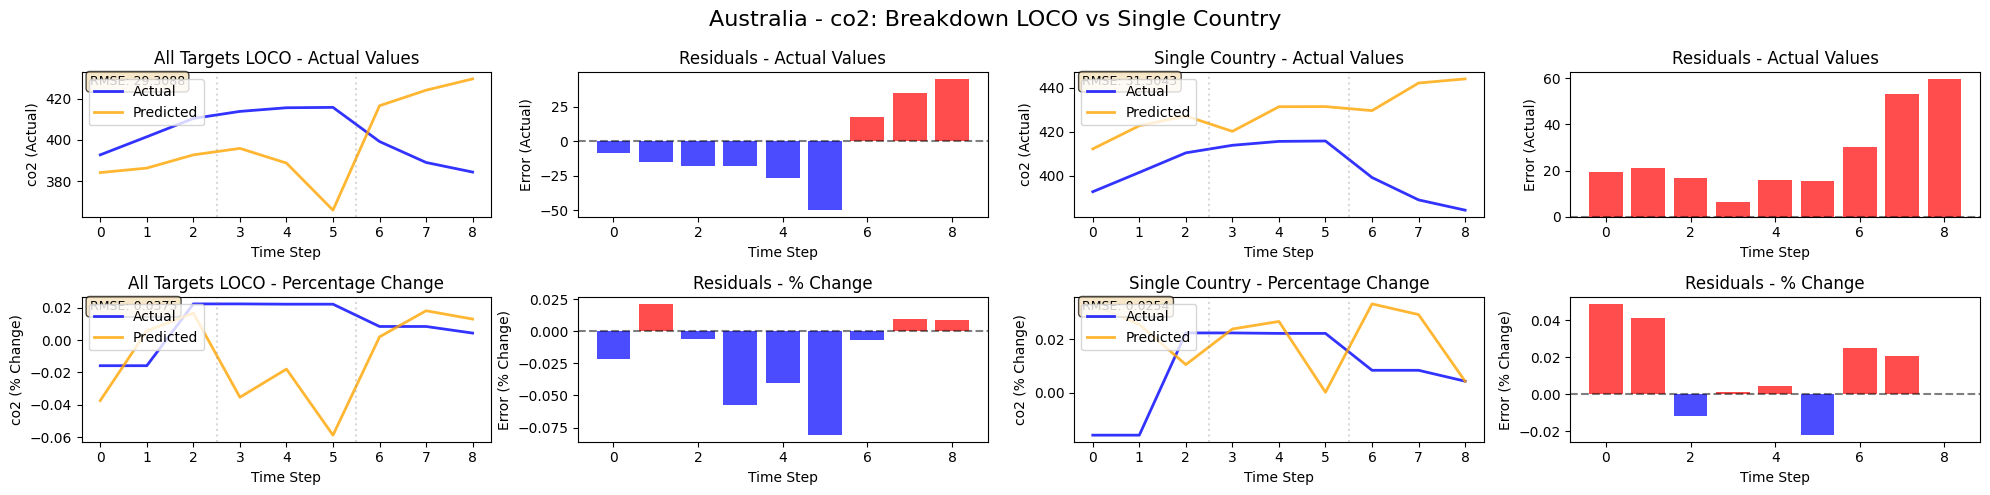


TESTING COUNTRY: South Korea

LOCO MODEL
All Targets LOCO for: South Korea
Predicting: co2 + its lags
Training data from 8 countries
Test country train samples: 24
Test country test samples: 9
Training seq: 265
Feature dim: 37
    Iter 0: Using last 5 train values
    Step 1: RMSE_pct=0.1217, RMSE_actual=77.2177
    Step 2: RMSE_pct=0.0623, RMSE_actual=121.8402
    Step 3: RMSE_pct=0.0132, RMSE_actual=112.5765
    Iter 1: Using last 2 train + test[0:3]
    Step 1: RMSE_pct=0.0183, RMSE_actual=11.6568
    Step 2: RMSE_pct=0.0054, RMSE_actual=15.5463
    Step 3: RMSE_pct=0.0585, RMSE_actual=55.1130
    Iter 2: Using test[1:6]
    Step 1: RMSE_pct=0.0933, RMSE_actual=60.2989
    Step 2: RMSE_pct=0.0200, RMSE_actual=48.9811
    Step 3: RMSE_pct=0.0611, RMSE_actual=88.5174

SINGLE COUNTRY MODEL

Single Country Model for South Korea
Predicting (co2) and all targets and their lags are used as features
Training samples: 24
Test samples: 9
Number of features: 37
Training seq: 17
Feature dim: 3

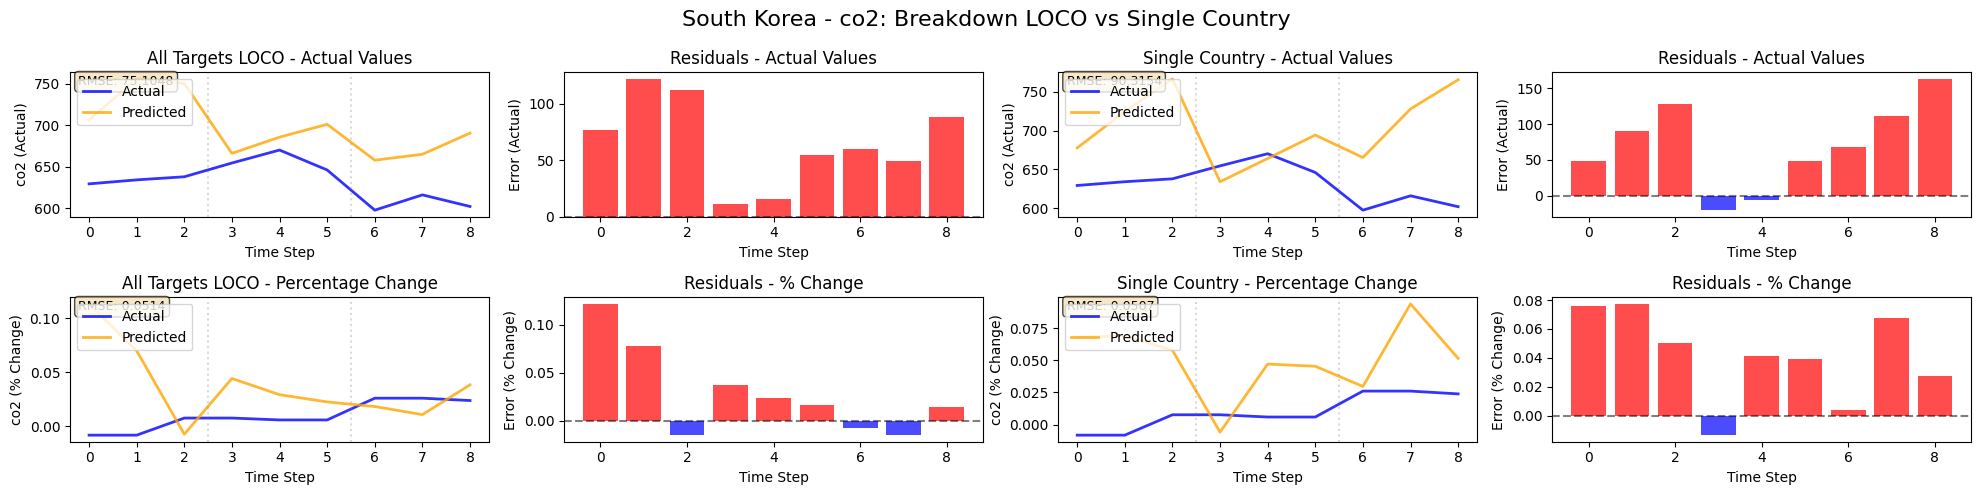


PERFORMANCE SUMMARY


In [121]:
bilstm_co2_results, bilstm_co2_summary = run_developed_bilstm_co2()